# 1.&nbsp;Libraries & paths & functions

## 1.1. Liberraries

In [2]:
# operating system
import os
import subprocess

# scientific python
import pandas as pd
import numpy as np

# plot
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.graph_objs as go

# netCDF4 data type
try:
    from netCDF4 import Dataset
except:
    _ = subprocess.run(["pip", "install", "netCDF4"])
    from netCDF4 import Dataset


## 1.2. Paths

In [ ]:
path_data = "/content/drive/MyDrive/5. Research/1. Summer Project/GIC/3. Data" ; display(os.listdir(path_data))


['images_GIC_data_download',
 'solar_wind_1995-2022.parq.gzip',
 'SuperMAG_1978-2021.parq.gzip',
 'README.md',
 'merged_1995-2011_2015.parq.gzip',
 'filled_merged_1995-2011_2015.parq.gzip']

## 1.3. Functions

In [ ]:
# Functions

# 1. print_details -------------------------------------------------------------
def print_details(dff, message1="", stage1=True):
    """
    Description:
        To print a message as well as the shape and the first row of a dataframe. Finally pass the dataframe.
    Parameters:
        dff (dataframe)
        message1 (str)
        stage1 (boolean) [optional]
    Returns:
        dff (dataframe)
    """
    if stage1:
        print( "\n Stage: {}".format(message1) )
    else:
        print( "\n Final: {}".format(message1) )
    display( dff.shape, dff.head(2) )
    return( dff )


# 2. solar_wind_web_scraping ---------------------------------------------------
def solar_wind_web_scraping(urls):

    """
    Scrapes Solar wind data from the provided URLs and saves it in a DataFrame.

    Parameters:
    urls (dict): A dictionary containing the URLs for each year's Solar wind data file.

    Returns:
    df_solar_wind (pandas.DataFrame): A DataFrame containing the concatenated Solar wind data from all years.

    The function takes a dictionary of URLs where each key represents a year and the corresponding value is the URL
    of the Solar wind data file for that year. It scrapes the data from the URLs, concatenates it into a single DataFrame,
    and saves it as a parquet file.

    The Solar wind data file should have the following columns:
    - year: Year of the data
    - day: Day of the year
    - hour: Hour of the day
    - minute: Minute of the hour
    - field_magnitude_average: Average magnitude of the field
    - Bx: Bx component of the field
    - By: By component of the field
    - Bz: Bz component of the field
    - speed: Speed of the Solar wind
    - Vx: Vx component of the Solar wind velocity
    - Vy: Vy component of the Solar wind velocity
    - Vz: Vz component of the Solar wind velocity
    - proton_density: Density of protons
    - proton_temperature: Temperature of protons
    - flow_pressure: Flow pressure
    - electric_field: Electric field
    - SYM/H: SYM/H parameter

    The function returns the concatenated DataFrame containing the Solar wind data from all years.

    Example:
    urls = {
        2019: "http://example.com/2019_SolarWindData.txt",
        2020: "http://example.com/2020_SolarWindData.txt",
        2021: "http://example.com/2021_SolarWindData.txt"
    }
    df_solar_wind = solar_wind_web_scraping(urls)
    """

    columns = [
        "year", "day", "hour", "minute",
        "field_magnitude_average", "Bx", "By", "Bz",
        "speed", "Vx", "Vy", "Vz",
        "proton_density", "proton_temperature",
        "flow_pressure", "electric_field",
        "SYM/H"
    ]

    # To concatenate all years of Solar wind data
    df_solar_wind = pd.DataFrame(columns=columns)
    years = list(urls.keys())
    for year in years:
        df_year = pd.read_csv(urls[year], delimiter=r"\s+", names=columns)
        df_solar_wind = pd.concat([df_solar_wind, df_year], axis=0)
    # display("df_solar_wind:", df_solar_wind.shape, df_solar_wind.head(2)) ; print()

    df_solar_wind = (
        df_solar_wind
        .assign(date_time=lambda df: pd.to_datetime(df.year * 1000 + df.day, format='%Y%j') +
                            pd.to_timedelta(df.hour, unit='h') +
                            pd.to_timedelta(df.minute, unit='m')
        )
        .drop(columns=["year", "day", "hour", "minute"])
        .filter(items=["date_time", # filter: To bring the date_time column at the first column
                    "field_magnitude_average", "Bx", "By", "Bz",
                    "speed", "Vx",	"Vy", "Vz",
                    "proton_density", "proton_temperature", "flow_pressure", "electric_field", "SYM/H"
                ]
    )
    )
    # display("df_solar_wind:", df_solar_wind.shape, df_solar_wind.head(2)) ; print()

    # To save the df_solar_wind dataset
    filename_solar_wind = f"solar_wind_{years[0]}-{years[-1]}.parq.gzip"
    df_solar_wind.to_parquet(filename_solar_wind, index=False, compression="gzip")
    df_solar_wind = pd.read_parquet(filename_solar_wind) ; display("df_solar_wind:", df_solar_wind.shape, df_solar_wind.head(2)) ; print()

    return (df_solar_wind)


# 3. SuperMAG_data_compression -------------------------------------------------
def SuperMAG_data_compression(path_data, filename1):

    """
    This function loads SuperMAG data from a .netCDF file, performs several transformations, and saves the final
    DataFrame as a gzip parquet file for efficient storage and future use.

    Parameters:
    path_data (str): The path to the directory where the .netCDF file is located.
    filename1 (str): The name of the .netCDF file.

    Returns:
    pandas.DataFrame: The final, transformed DataFrame.

    The function performs the following steps:
    1. It loads the .netCDF file into a pandas DataFrame, where each variable in the .netCDF file becomes a column in the DataFrame.
    2. It drops the 'extent', 'glat', 'glon', and 'id' columns which have been identified as unneeded due to only having a single unique value each.
    3. It creates a new 'date_time' column by combining several time-related columns in the original DataFrame.
    4. It saves the final DataFrame as a gzip parquet file with a name based on the range of years included in the data.
        The file is saved in the same directory as the original .netCDF file.
    5. It re-loads the saved DataFrame from the parquet file and returns it.

    Note: If the netCDF4 library is not installed, the function will attempt to install it using pip.

    Example:
    ```
    path = "/path/to/your/netCDF/file"
    filename = "SuperMAG_data.netCDF"
    df = SuperMAG_data_compression(path, filename)
    ```
    """

    try:
        from netCDF4 import Dataset
    except:
        _ = subprocess.run(["pip", "install", "netCDF4"])
        from netCDF4 import Dataset

    netcdf1 = Dataset(os.path.join(path_data, filename1), 'r')

    columns = [var for var in netcdf1.variables]

    df_SuperMAG = pd.DataFrame()
    for var in columns:
        df_var = pd.DataFrame(netcdf1.variables[var][:], columns=[var])
        df_SuperMAG = pd.concat([df_SuperMAG, df_var], axis=1)
    # display("df_SuperMAG:", df_SuperMAG.shape, df_SuperMAG.head(2)) ; print()
    netcdf1.close()

    datetime_cols_dict = {
            "time_yr":"year",
            "time_mo":"month",
            "time_dy":"day",
            "time_hr":"hour",
            "time_mt":"minute",
            "time_sc":"second",
    }

    df_SuperMAG = (
        df_SuperMAG
        .rename(columns=datetime_cols_dict)
        .assign(date_time = lambda df:pd.to_datetime(df.filter(items=list(datetime_cols_dict.values()))))
        .drop(columns=["extent", "glat", "glon", "id"]+list(datetime_cols_dict.values()))
        .filter(items=["date_time", # filter: To bring the date_time column at the first column
                       "dbe_geo", "dbe_nez",
                       "dbn_geo", "dbn_nez",
                       "dbz_geo", "dbz_nez",
                       "decl", "mcolat", "mlat", "mlon", "mlt", "sza"
                ]
        )
    )

    # To save the df_SuperMAG dataset
    start_year = df_SuperMAG.date_time.dt.year.min()
    end_year = df_SuperMAG.date_time.dt.year.max()
    filename_SuperMAG = f"SuperMAG_{start_year}-{end_year}.parq.gzip"
    df_SuperMAG.to_parquet(os.path.join(path_data, filename_SuperMAG), index=False, compression="gzip")
    df_SuperMAG = pd.read_parquet(os.path.join(path_data, filename_SuperMAG)) ; display("df_SuperMAG:", df_SuperMAG.shape, df_SuperMAG.head(2)) ; print()

    return(df_SuperMAG)


# 4. missing_values_report -----------------------------------------------------
def missing_values_report(df):
    """
    Generates a report of missing values for a given DataFrame.

    Args:
    df (DataFrame): The DataFrame for which the missing values report is to be generated.

    Returns:
    DataFrame: A DataFrame containing the count and percentage of missing values for each column.

    Example:
    >>> df = pd.DataFrame({'A': [1, 2, None], 'B': [4, None, 6]})
    >>> missing_values_report(df)
      the_number_of_missing_values  Percentage (%)
    A                          1              33
    B                          1              33
    """
    missing_count = df.isnull().sum()
    total_count = len(df)
    missing_percentage = round((missing_count / total_count) * 100).astype(int)
    df_missing_values_report = pd.DataFrame({
        'the_number_of_missing_values': missing_count,
        'Percentage (%)': missing_percentage
    })
    return df_missing_values_report


# 5. minutes_in_years ----------------------------------------------------------
def minutes_in_years(start, end):
    """
    min per year:
    There are two types of years:
        leap years: 366 days
        non-leap years: 365 days

    The rules for determining whether a year is a leap year or not are as follows:
        1. If a year is evenly divisible by 4, it is a leap year, except:
        2. If that year is also evenly divisible by 100, it is not a leap year, unless:
        3. That year is also evenly divisible by 400, in which case it is a leap year.
            So while the year 100 is evenly divisible by 4, it is also evenly divisible by 100.
            Since it is not evenly divisible by 400, it does not meet the third criteria, and therefore it is not a leap year.

    These rules are in place to correct for the fact that a solar year (the length of time it takes for the Earth to orbit the Sun once) is not exactly 365.25 days,
    but is approximately 365.2425 days.
    By skipping the leap day in years divisible by 100 (but not by 400), the Gregorian calendar maintains its alignment with the solar year over the centuries.

    0.0025 (day) * 400 = 1 (day) So, days = 366 if ((year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)) else 365

    # use the function
    >>> for year, minutes in minutes_in_years(1995, 2015):
    >>>     print(f"{year}: {minutes}")

    1995: 525600
    1996: 527040
    1997: 525600
    1998: 525600
    1999: 525600
    2000: 527040
    2001: 525600
    2002: 525600
    2003: 525600
    2004: 527040
    2005: 525600
    2006: 525600
    2007: 525600
    2008: 527040
    2009: 525600
    2010: 525600
    2011: 525600
    2012: 527040
    2013: 525600
    2014: 525600
    2015: 525600
    """
    minutes_per_day = 24 * 60
    for year in range(start, end + 1):
        days = 366 if ((year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)) else 365
        yield year, days * minutes_per_day



# 2.&nbsp;Data acquisition method

## 2.1. Solar wind data (OMNIWeb)

1. Open OMNIWeb Link (https://omniweb.gsfc.nasa.gov/)
2. Follow the instructions below


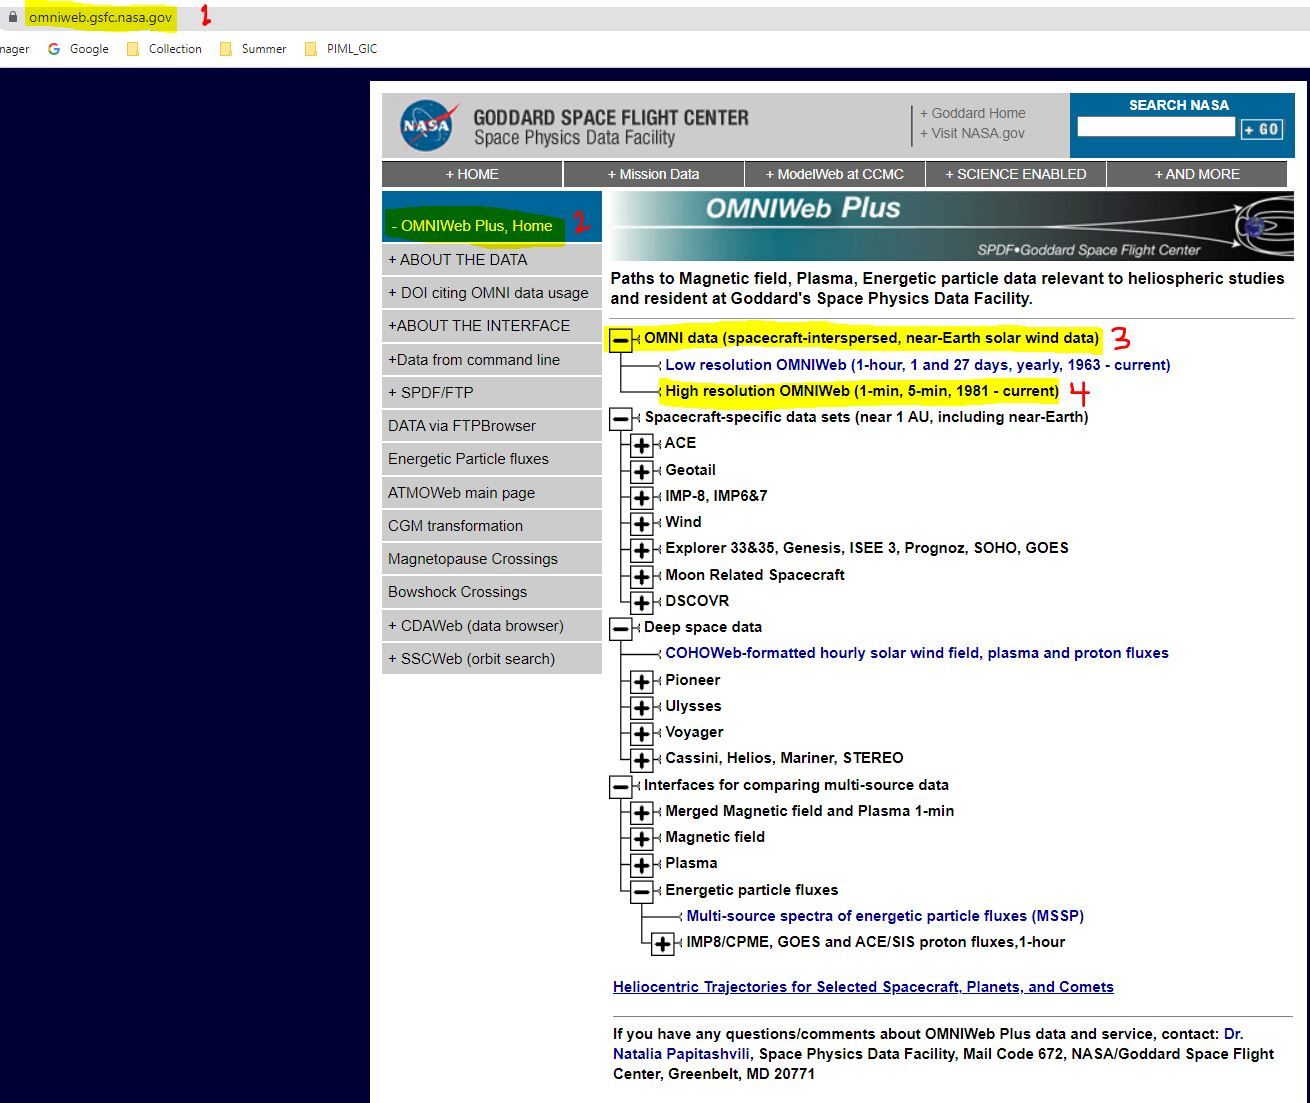

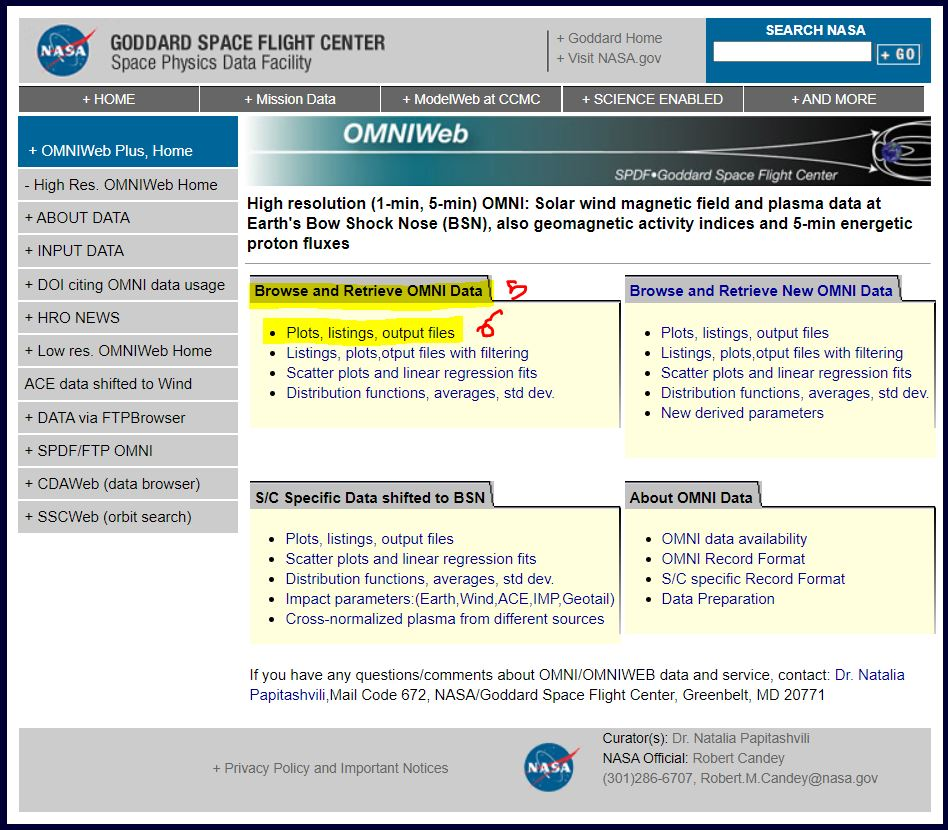

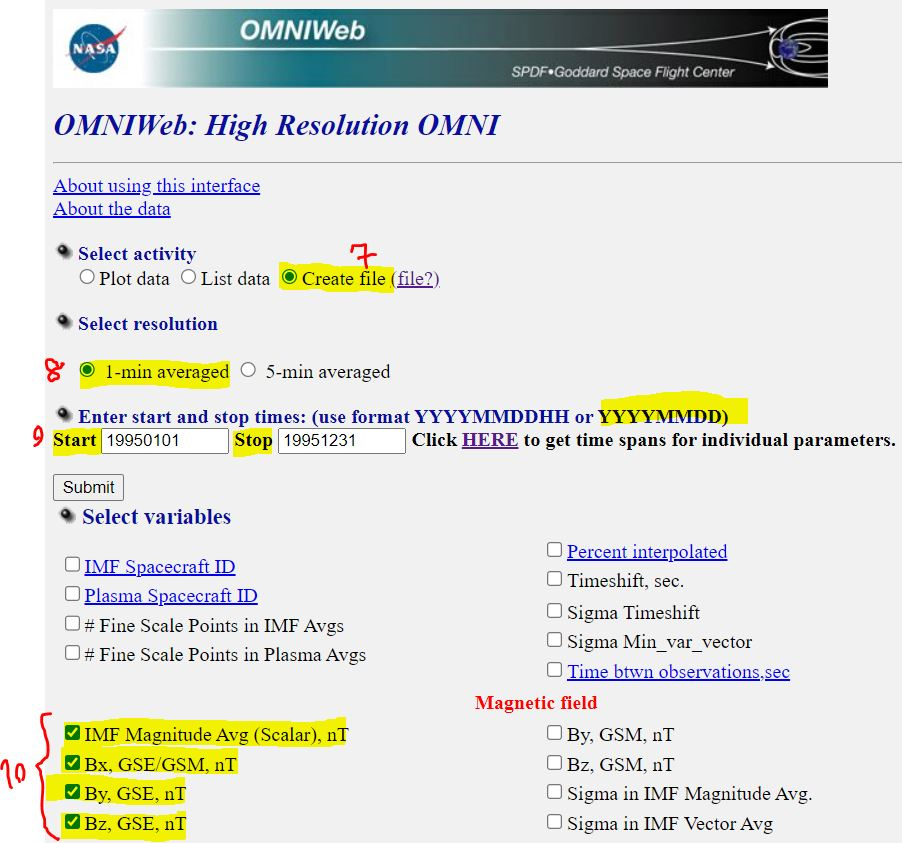

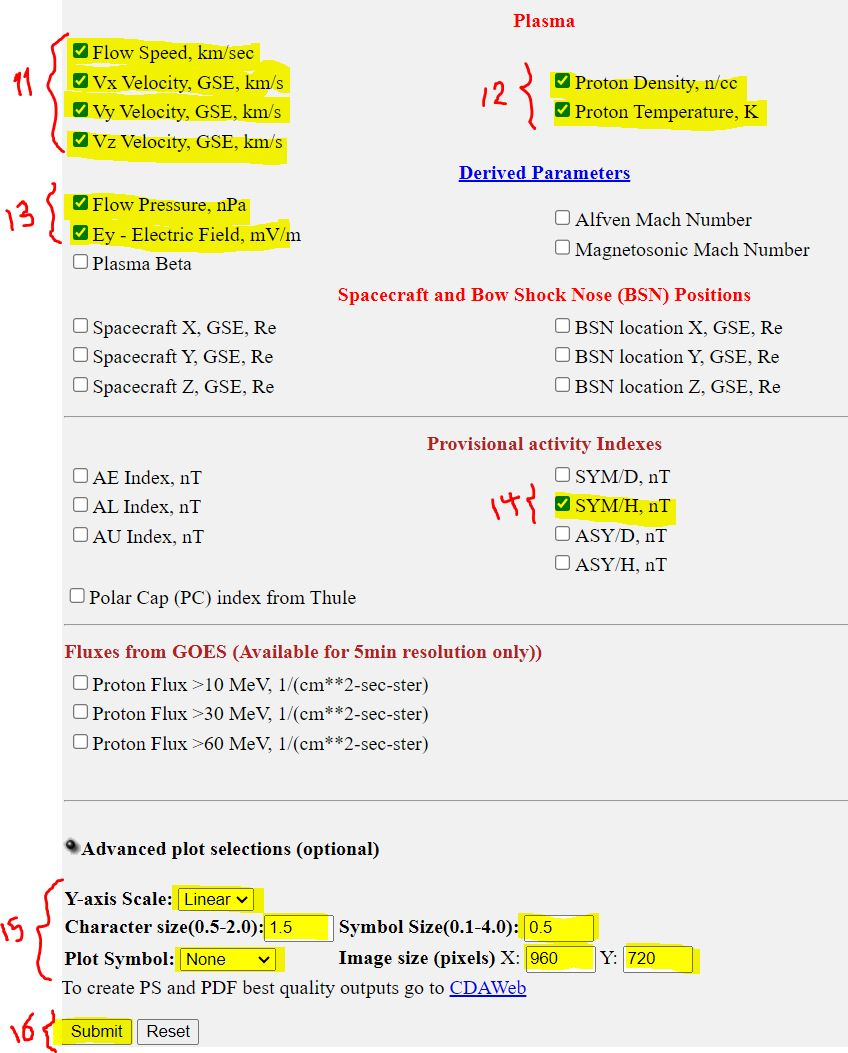

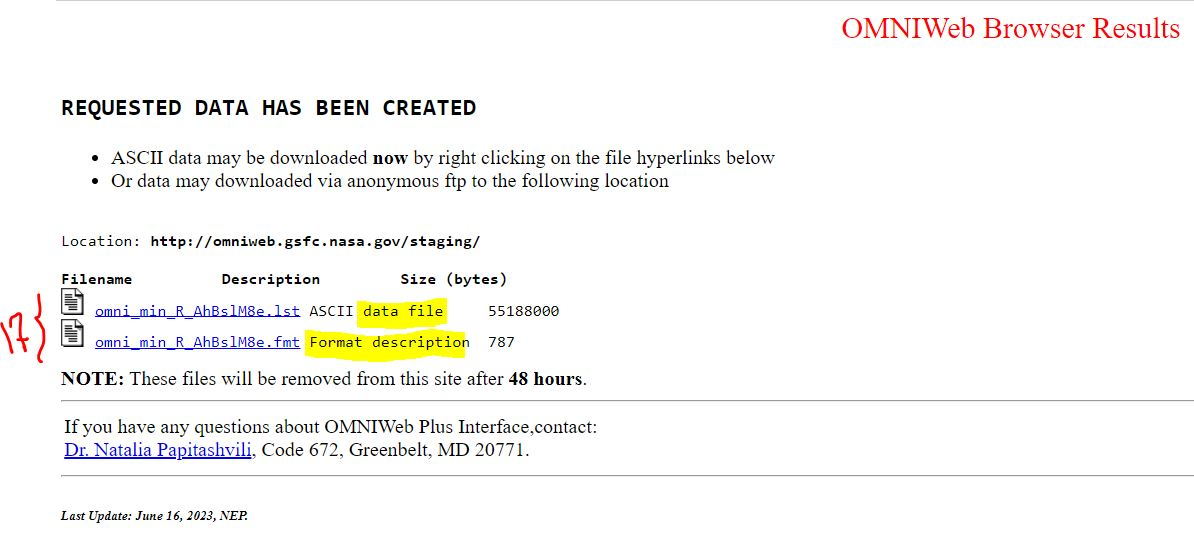

## 2.2. SuperMAG data

1. Open OMNIWeb Link (https://supermag.jhuapl.edu/)
2. Follow the instructions below


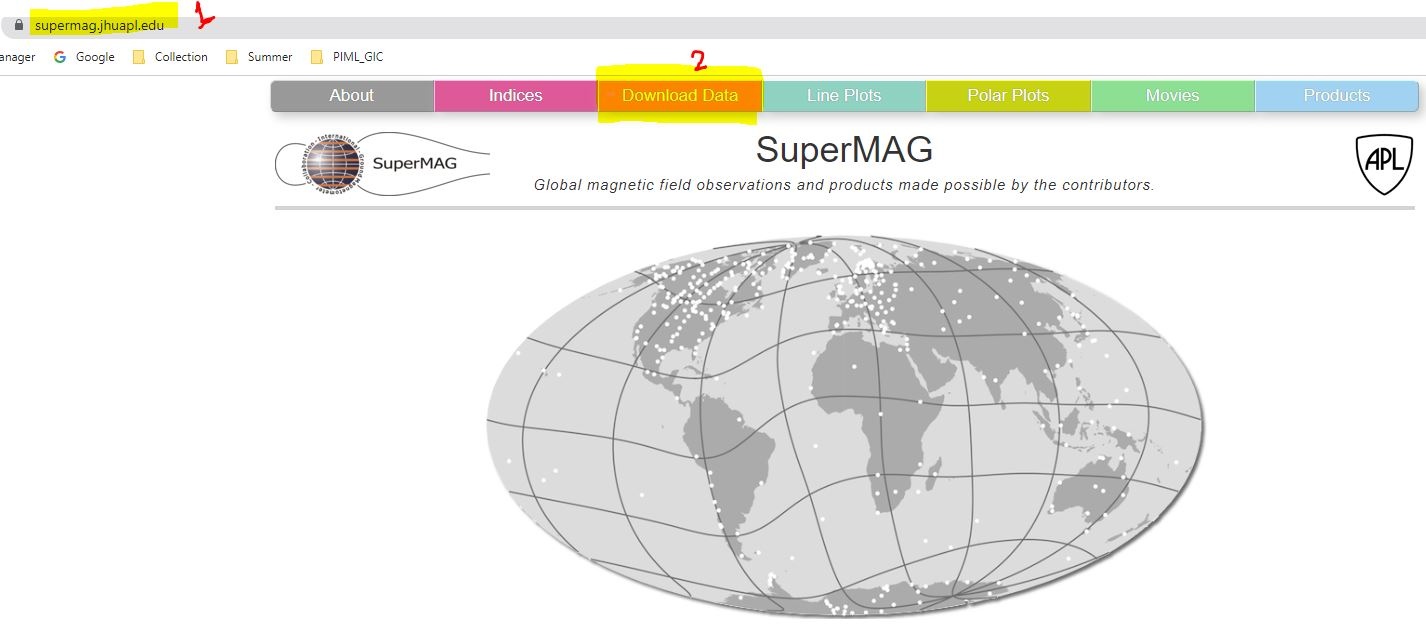

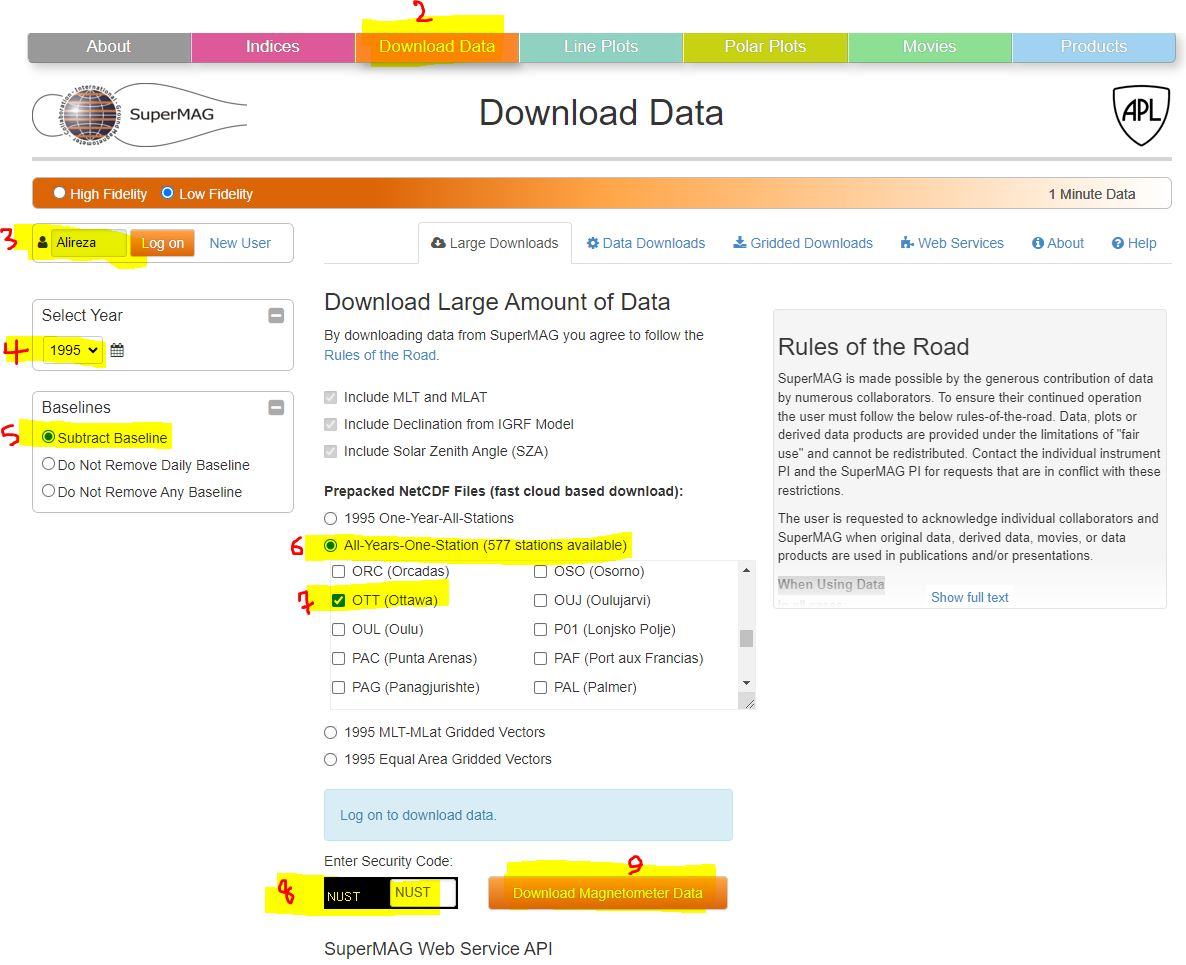

# 3.&nbsp;Data acquisition and compression

## 3.1. Solar wind data

### 3.1.1. Description

**Description**

Here is a description for each column in your "Solar wind Omniweb" dataset:

**year**: The year in which the observation was made.

**day**: The day of the year when the observation was made, typically ranging from 1 to 365 (or 366 in leap years).

**hour**: The hour of the day (in a 24-hour format) when the observation was made.

**minute**: The minute of the hour when the observation was made.

**field_magnitude_average**: This is the average magnitude of the Interplanetary Magnetic Field (IMF) over the given period. The IMF is carried by solar wind and extends from the sun.

**Bx, By, Bz**: These are components of the IMF in the Geocentric Solar Magnetospheric (GSM) coordinate system. Bx is the Earth-Sun direction component, By is perpendicular to the Earth-Sun line within the ecliptic plane, and Bz is perpendicular to the ecliptic plane (northward).

**speed**: The speed of the solar wind, usually measured in kilometers per second.

**Vx, Vy, Vz**: These are the components of the solar wind velocity in the GSM coordinate system.

**proton_density**: The density of protons in the solar wind, typically measured in protons per cubic centimeter.

**proton_temperature**: The temperature of the solar wind protons, usually measured in Kelvin.

**flow_pressure**: The dynamic pressure of the solar wind, typically measured in nanoPascals. It depends on the solar wind's density and speed.

**electric_field**: This likely refers to the electric field in the solar wind, typically influenced by the solar wind speed and the IMF.

**SYM/H**: A geomagnetic index that measures the symmetric part of the disturbance magnetic field in the horizontal plane at the Earth's surface. It can help in identifying and measuring the intensity of geomagnetic storms.

### 3.1.2. Code (Do not run it!)

In [ ]:
# Note:
#   The links below will expire after 24 hours. But it's not a problem because we only read the datasets once and then save them in a single parquet file.
urls = {
    1995:"http://omniweb.gsfc.nasa.gov/staging/omni_min_WPz8o80Je1.lst",
    1996:"http://omniweb.gsfc.nasa.gov/staging/omni_min__mWAY1KGXB.lst",
    1997:"http://omniweb.gsfc.nasa.gov/staging/omni_min_bRTIvM2tjl.lst",
    1998:"http://omniweb.gsfc.nasa.gov/staging/omni_min_QjDfhgPAk1.lst",
    1999:"http://omniweb.gsfc.nasa.gov/staging/omni_min_WUi62Lm_z7.lst",
    2000:"http://omniweb.gsfc.nasa.gov/staging/omni_min_F4C29n8rDa.lst",
    2001:"http://omniweb.gsfc.nasa.gov/staging/omni_min_DsD1ZtYvm7.lst",
    2002:"http://omniweb.gsfc.nasa.gov/staging/omni_min_FEqatAmX1n.lst",
    2003:"http://omniweb.gsfc.nasa.gov/staging/omni_min_b5LmphkKnK.lst",
    2004:"http://omniweb.gsfc.nasa.gov/staging/omni_min_x4QrAEJ70Z.lst",
    2005:"http://omniweb.gsfc.nasa.gov/staging/omni_min_NgK2TpXeEG.lst",
    2006:"http://omniweb.gsfc.nasa.gov/staging/omni_min_1oLTQd5ThC.lst",
    2007:"http://omniweb.gsfc.nasa.gov/staging/omni_min_hhw9ltigni.lst",
    2008:"http://omniweb.gsfc.nasa.gov/staging/omni_min_cR0D1MKaTi.lst",
    2009:"http://omniweb.gsfc.nasa.gov/staging/omni_min_J57Sx8m8RN.lst",
    2010:"http://omniweb.gsfc.nasa.gov/staging/omni_min_imJhAjMVdI.lst",
    2011:"http://omniweb.gsfc.nasa.gov/staging/omni_min_nDVNkiBfBP.lst",
    2012:"http://omniweb.gsfc.nasa.gov/staging/omni_min_JAiF_lFZQ_.lst",
    2013:"http://omniweb.gsfc.nasa.gov/staging/omni_min_8m7A_lPmNf.lst",
    2014:"http://omniweb.gsfc.nasa.gov/staging/omni_min_RZh4xnWwX9.lst",
    2015:"http://omniweb.gsfc.nasa.gov/staging/omni_min_WHZJchxh45.lst",
    2016:"http://omniweb.gsfc.nasa.gov/staging/omni_min_o2KQdCUi1M.lst",
    2017:"http://omniweb.gsfc.nasa.gov/staging/omni_min_XIcTeTcxMO.lst",
    2018:"http://omniweb.gsfc.nasa.gov/staging/omni_min_1NsIci9LCc.lst",
    2019:"http://omniweb.gsfc.nasa.gov/staging/omni_min_ISba1SdaZC.lst",
    2020:"http://omniweb.gsfc.nasa.gov/staging/omni_min_w155smJ855.lst",
    2021:"http://omniweb.gsfc.nasa.gov/staging/omni_min_sqdqxKg9zP.lst",
    2022:"http://omniweb.gsfc.nasa.gov/staging/omni_min_z4x2sMrH2g.lst",
}
df_solar_wind = solar_wind_web_scraping(urls) ; display("df_solar_wind:", df_solar_wind.shape, df_solar_wind.head(2)) ; print()


'df_solar_wind:'

(14726880, 14)

,date_time,field_magnitude_average,Bx,By,Bz,speed,Vx,Vy,Vz,proton_density,proton_temperature,flow_pressure,electric_field,SYM/H
0,1995-01-01,1.35,0.19,0.9,-0.98,99999.9,99999.9,99999.9,99999.9,999.99,9999999.0,99.99,999.99,12


**Note**:   
The above cell should not run because its links have expired. The bottom cell of the screenshot is the result of the top cell so that if the top cell is run by mistake, we have the result here.

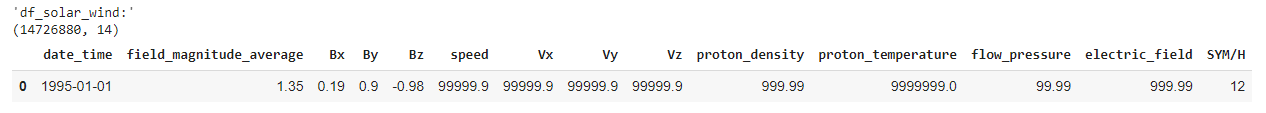

In [ ]:
df_solar_wind.isna().sum()

date_time                  0
field_magnitude_average    0
Bx                         0
By                         0
Bz                         0
speed                      0
Vx                         0
Vy                         0
Vz                         0
proton_density             0
proton_temperature         0
flow_pressure              0
electric_field             0
SYM/H                      0
dtype: int64

In [ ]:
df_solar_wind.dtypes

date_time                  datetime64[ns]
field_magnitude_average           float64
Bx                                float64
By                                float64
Bz                                float64
speed                             float64
Vx                                float64
Vy                                float64
Vz                                float64
proton_density                    float64
proton_temperature                float64
flow_pressure                     float64
electric_field                    float64
SYM/H                               int64
dtype: object

## 3.2. SuperMAG data

### 3.2.1. All years

#### 3.2.1.1. Description

We downloaded `Supermag_all_years.netcdf`. Then, we compressed and saved it as `SuperMAG_1978-2021.parq.gzip`.

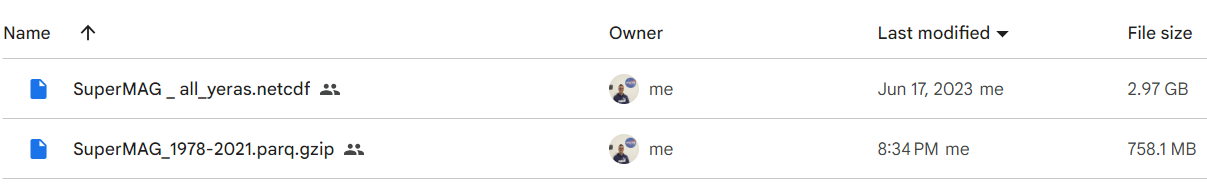

**Description**

Here is a description of each of the column names in SuperMAG dataset:

**date_time**: The timestamp for each observation. This could be in various formats, but often it's in UTC (Coordinated Universal Time).

**dbe_geo**: The eastward component of the magnetic field variation (delta B) in geographic coordinates. It's typically measured in nano-Tesla (nT).

**dbe_nez**: The eastward component of the magnetic field variation (delta B) in North-East-Down (NED) or North-East-Z (NEZ) coordinates.

**dbn_geo**: The northward component of the magnetic field variation (delta B) in geographic coordinates.

**dbn_nez**: The northward component of the magnetic field variation (delta B) in NEZ coordinates.

**dbz_geo**: The downward (or vertical) component of the magnetic field variation (delta B) in geographic coordinates.

**dbz_nez**: The downward (or vertical) component of the magnetic field variation (delta B) in NEZ coordinates.

**decl**: The magnetic declination at the magnetometer station, i.e., the angle between geographic north (true north) and magnetic north.

**mcolat**: Magnetic co-latitude of the magnetometer station. This is 90 degrees minus the magnetic latitude, so it measures the angle from the magnetic north pole.

**mlat**: Magnetic latitude of the magnetometer station.

**mlon**: Magnetic longitude of the magnetometer station.

**mlt**: Magnetic Local Time at the magnetometer station. This is a measure of solar time based on the location's magnetic longitude.

**sza**: Solar Zenith Angle. This is the angle between the line perpendicular to the Earth's surface at a given location and the line from that location to the Sun. It's an indicator of the Sun's position in the sky and can be used to infer the level of solar radiation reaching the location.

#### 3.2.1.2. Code

In [ ]:
filename1 = "SuperMAG _ all_yeras.netcdf"
df_SuperMAG = SuperMAG_data_compression(path_data, filename1)


'df_SuperMAG:'

(23142240, 13)

,date_time,dbe_geo,dbe_nez,dbn_geo,dbn_nez,dbz_geo,dbz_nez,decl,mcolat,mlat,mlon,mlt,sza
0,1978-01-01 00:00:00,12.604650,12.604650,11.976033,8.66855,2.154181,2.154181,-13.629668,32.584026,57.415974,-0.387827,18.810303,115.530296
1,1978-01-01 00:01:00,12.523906,12.523906,11.942122,8.65462,2.163724,2.163724,-13.629668,32.584026,57.415974,-0.387827,18.826981,115.704193


In [ ]:
df_SuperMAG.isna().sum()

date_time         0
dbe_geo      214340
dbe_nez      214340
dbn_geo      214340
dbn_nez      214340
dbz_geo      214340
dbz_nez      214340
decl              0
mcolat            0
mlat              0
mlon              0
mlt               0
sza               0
dtype: int64

In [ ]:
# The number of days with missing data
# min=60, hour=24,
days = 214340/(60*24)
print(days)

# The percentage of missing data
round(214340 / 23142240, 3)

148.84722222222223


0.009

### 3.2.2. Year by year (1995)

#### 3.2.2.1.  Description

- **Source 1**:
    - https://supermag.jhuapl.edu/

- **Disclaimer**:
    ```
    ********************************************************
    *              THESE ARE NOT FINAL DATA                *
    * DESPITE EXTENSIVE CLEANING NUMEROUS BUGS STILL EXIST *
    *        CHECK DATA QUALITY BEFORE PUBLICATION         *
    ********************************************************
    ```
- **N, E, Z**:
    - File contains N, E, Z from individual ground magnetometer stations.    
        - The coordinate system is defined as:
            - N is positive in the direction of local magnetic north;
            - E is positive in the local magnetic east direction;
            - Z is positive vertical down.

- **Acknowledgements**:    
In case data are used in publications or presentations the following text **must be used for acknowledgements**:

    > ```For the ground magnetometer data we gratefully acknowledge:
  INTERMAGNET, Alan Thomson; CARISMA, PI Ian Mann; CANMOS,
  Geomagnetism Unit of the Geological Survey of Canada; The S-RAMP
  Database, PI K. Yumoto and Dr. K. Shiokawa; The SPIDR database;
  AARI, PI Oleg Troshichev; The MACCS program, PI M. Engebretson;
  GIMA; MEASURE, UCLA IGPP and Florida Institute of Technology;
  SAMBA, PI Eftyhia Zesta; 210 Chain, PI K. Yumoto; SAMNET, PI
  Farideh Honary; IMAGE, PI Liisa Juusola; Finnish Meteorological
  Institute, PI Liisa Juusola; Sodankylä Geophysical Observatory,
  PI Tero Raita; UiT the Arctic University of Norway, Tromsø
  Geophysical Observatory, PI Magnar G. Johnsen; GFZ German
  Research Centre For Geosciences, PI Jürgen Matzka; Institute of
  Geophysics, Polish Academy of Sciences, PI Anne Neska and Jan
  Reda; Polar Geophysical Institute, PI Alexander Yahnin and Yarolav
  Sakharov; Geological Survey of Sweden, PI Gerhard Schwarz; Swedish
  Institute of Space Physics, PI Masatoshi Yamauchi; AUTUMN, PI
  Martin Connors; DTU Space, Thom Edwards and PI Anna Willer;
  South Pole and McMurdo Magnetometer, PI's Louis J. Lanzarotti
  and Alan T. Weatherwax; ICESTAR; RAPIDMAG; British Artarctic
  Survey; McMac, PI Dr. Peter Chi; BGS, PI Dr. Susan Macmillan;
  Pushkov Institute of Terrestrial Magnetism, Ionosphere and Radio
  Wave Propagation (IZMIRAN);  MFGI, PI B. Heilig; Institute of
  Geophysics, Polish Academy of Sciences, PI Anne Neska and Jan
  Reda; University of L’Aquila, PI M. Vellante; BCMT, V. Lesur and
  A. Chambodut; Data obtained in cooperation with Geoscience
  Australia, PI Andrew Lewis; AALPIP, co-PIs Bob Clauer and
  Michael Hartinger; MagStar, PI Jennifer Gannon; SuperMAG, PI
  Jesper W. Gjerloev; Data obtained in cooperation with the
  Australian Bureau of Meteorology, PI Richard Marshall.
  ```

- **Contact**:
>```Comments, questions or suggestions should be directed to:
    Dr. Jesper W. Gjerloev
    Johns Hopkins University
    Applied Physics Laboratory
    11100 Johns Hopkins Road
    Laurel, Maryland 20723
    (+1) 240-228-5410
    Jesper.Gjerloev@jhuapl.edu
```

- **Meta data**:     
>```
This file downloaded from http://supermag.jhuapl.edu on 2023-06-26T01:48:51Z   
Data Revision:0006   
Interval: 1995-01-01T00:00:00.000 - 1996-01-01T00:00:00.000 Step: 60 seconds   
Fill/Gap Value: NaN    
Stations Selected: OTT    
Baseline Subtraction: All   
Parameters: IAGA Station ID | Geo. Lon. | Geo. Lat. | Mag. Lon.| Mag. Lat. | MLT | Mag Colat. | Mag. Declination | Solar Zenith Angle | Mag. Field NEZ | Mag. Field Geo.    
```

**Source 2**:
- Web search by Alireza Motazedian.

**Features**:

**Date_UTC**: This represents the timestamp of the observation in Coordinated Universal Time (UTC).

**Extent**: This could potentially represent the extent of a particular magnetic event, but without specific documentation, it's hard to say exactly. It could also be a geographic or magnetic extent, such as the coverage of a magnetometer station.

**IAGA**: This stands for International Association of Geomagnetism and Aeronomy. The IAGA code is a unique identifier given to each magnetometer station.

**GEOLON (Geographic Longitude)**: This is the geographic longitude of the magnetometer station, measured in degrees from -180 to +180.

**GEOLAT (Geographic Latitude)**: This is the geographic latitude of the magnetometer station, measured in degrees from -90 (South Pole) to +90 (North Pole).

**MAGON (Magnetic Longitude)**: This is the longitude of the magnetometer station in geomagnetic coordinates.

**MAGLAT (Magnetic Latitude)**: This is the latitude of the magnetometer station in geomagnetic coordinates.

**MLT (Magnetic Local Time)**: This is a measure of solar time based on the location's magnetic longitude.

**MCOLAT (Magnetic Co-latitude)**: This is 90 degrees minus the magnetic latitude, measuring the angle from the magnetic north pole.

**IGRF_DECL (International Geomagnetic Reference Field Declination)**: This is the angle between magnetic north and true north at a particular location, according to the International Geomagnetic Reference Field model.

**SZA (Solar Zenith Angle)**: This is the angle between the line perpendicular to the Earth's surface at a given location and the line from that location to the Sun. It can be used to infer the level of solar radiation reaching the location.

**dbn_nez, dbe_nez, dbz_nez**: These represent the changes (delta, denoted by 'db') in the northward, eastward, and downward components of the magnetic field in NEZ (North, East, Down) coordinates.

**dbn_geo, dbe_geo, dbz_geo**: These represent the changes (delta, denoted by 'db') in the northward, eastward, and downward components of the magnetic field in geographic coordinates.

#### 3.2.2.2. Code

In [ ]:
filename_SuperMAG_1995 = "SuperMAG_1995.csv"
df_SuperMAG_Year_by_year_1995 = (
    pd.read_csv(os.path.join(path_data, filename_SuperMAG_1995))
) ; display("df_SuperMAG_Year_by_year_1995:", df_SuperMAG_Year_by_year_1995.shape, df_SuperMAG_Year_by_year_1995.head(2)) ; print()


'df_SuperMAG_Year_by_year_1995:'

(525600, 17)

,Date_UTC,Extent,IAGA,GEOLON,GEOLAT,MAGON,MAGLAT,MLT,MCOLAT,IGRF_DECL,SZA,dbn_nez,dbe_nez,dbz_nez,dbn_geo,dbe_geo,dbz_geo
0,1995-01-01T00:00:00,60,OTT,284.45,45.4,0.75,56.33,18.89,33.67,-14.41,115.55,3.9,-0.7,4.8,3.6,-1.7,4.8
1,1995-01-01T00:01:00,60,OTT,284.45,45.4,0.75,56.33,18.91,33.67,-14.41,115.73,3.9,-0.7,4.8,3.6,-1.7,4.8


In [ ]:
columns_all_years = df_SuperMAG.columns
filename_SuperMAG_1995 = "SuperMAG_1995.csv"
df_SuperMAG_Year_by_year_1995 = (
    pd.read_csv(os.path.join(path_data, filename_SuperMAG_1995))
    .drop(columns=["Extent", "IAGA", "GEOLON", "GEOLAT"])
    .rename(columns={
        "Date_UTC":"date_time",
        "MAGON":"mlon",
        "MAGLAT":"mlat",
        "MLT":"mlt",
        "MCOLAT":"mcolat",
        "IGRF_DECL":"decl",
        "SZA":"sza",
    })
    .filter(items=columns_all_years)
) ; display("df_SuperMAG_Year_by_year_1995:", df_SuperMAG_Year_by_year_1995.shape, df_SuperMAG_Year_by_year_1995.head(2)) ; print()


'df_SuperMAG_Year_by_year_1995:'

(525600, 13)

,date_time,dbe_geo,dbe_nez,dbn_geo,dbn_nez,dbz_geo,dbz_nez,decl,mcolat,mlat,mlon,mlt,sza
0,1995-01-01T00:00:00,-1.7,-0.7,3.6,3.9,4.8,4.8,-14.41,33.67,56.33,0.75,18.89,115.55
1,1995-01-01T00:01:00,-1.7,-0.7,3.6,3.9,4.8,4.8,-14.41,33.67,56.33,0.75,18.91,115.73


### 3.2.3. all_years vs. year_by_year

In [ ]:
# We already have the all years data
filename_SuperMAG_all_years = "SuperMAG_1978-2021.parq.gzip"
df_SuperMAG = pd.read_parquet(os.path.join(path_data, filename_SuperMAG_all_years)) ; display("df_SuperMAG:", df_SuperMAG.shape, df_SuperMAG.head(2)) ; print()
# We filter all year data for 1995
condition1 = (df_SuperMAG['date_time'].dt.year == 1995)
df_SuperMAG_filtered_1995 = df_SuperMAG.loc[condition1, :].reset_index(drop=True) ; display("df_SuperMAG_filtered_1995:", df_SuperMAG_filtered_1995.shape, df_SuperMAG_filtered_1995.head(2)) ; print()


'df_SuperMAG:'

(23142240, 13)

,date_time,dbe_geo,dbe_nez,dbn_geo,dbn_nez,dbz_geo,dbz_nez,decl,mcolat,mlat,mlon,mlt,sza
0,1978-01-01 00:00:00,12.604650,12.604650,11.976033,8.66855,2.154181,2.154181,-13.629668,32.584026,57.415974,-0.387827,18.810303,115.530296
1,1978-01-01 00:01:00,12.523906,12.523906,11.942122,8.65462,2.163724,2.163724,-13.629668,32.584026,57.415974,-0.387827,18.826981,115.704193


'df_SuperMAG_filtered_1995:'

(525600, 13)

,date_time,dbe_geo,dbe_nez,dbn_geo,dbn_nez,dbz_geo,dbz_nez,decl,mcolat,mlat,mlon,mlt,sza
0,1995-01-01 00:00:00,-1.656206,-1.656206,3.560276,3.860474,4.760194,4.760194,-14.413527,33.673729,56.326271,0.749585,18.892572,115.552635
1,1995-01-01 00:01:00,-1.681890,-1.681890,3.577185,3.883245,4.756423,4.756423,-14.413527,33.673729,56.326271,0.749586,18.909193,115.726540


In [ ]:
# Let's Compare two datasets
display("df_SuperMAG_filtered_1995:", df_SuperMAG_filtered_1995.shape, df_SuperMAG_filtered_1995.head(2)) ; print()

display("df_SuperMAG_Year_by_year_1995:", df_SuperMAG_Year_by_year_1995.shape, df_SuperMAG_Year_by_year_1995.head(2)) ; print()


'df_SuperMAG_filtered_1995:'

(525600, 13)

,date_time,dbe_geo,dbe_nez,dbn_geo,dbn_nez,dbz_geo,dbz_nez,decl,mcolat,mlat,mlon,mlt,sza
0,1995-01-01 00:00:00,-1.656206,-1.656206,3.560276,3.860474,4.760194,4.760194,-14.413527,33.673729,56.326271,0.749585,18.892572,115.552635
1,1995-01-01 00:01:00,-1.681890,-1.681890,3.577185,3.883245,4.756423,4.756423,-14.413527,33.673729,56.326271,0.749586,18.909193,115.726540


'df_SuperMAG_Year_by_year_1995:'

(525600, 13)

,date_time,dbe_geo,dbe_nez,dbn_geo,dbn_nez,dbz_geo,dbz_nez,decl,mcolat,mlat,mlon,mlt,sza
0,1995-01-01T00:00:00,-1.7,-0.7,3.6,3.9,4.8,4.8,-14.41,33.67,56.33,0.75,18.89,115.55
1,1995-01-01T00:01:00,-1.7,-0.7,3.6,3.9,4.8,4.8,-14.41,33.67,56.33,0.75,18.91,115.73


**Notes**:
- `yera by year` is the rounded version of `all years`.
- **Wierd feature**: The values of column `dbe_nez` in these datasets are not the same. We should contact the providers, or just report in our publications. ???

**Conclusion**:
- we use `all years` because it is more accurate.

# 4.&nbsp;Merge datasets

## 4.1. Solar wind data

In [ ]:
filename1 = "solar_wind_1995-2022.parq.gzip"

df_solar_wind = (
    pd.read_parquet(os.path.join(path_data, filename1))
    .drop(columns=["SYM/H"])
    .rename(columns={
        "field_magnitude_average":"BT", # BT: resultant of Bx, By, Bz.
        "speed":"VT",                   # VT: resultant of Vx, Vy, Vz.
        "proton_density":"n_p",
        "proton_temperature":"T_p",
        "flow_pressure":"P_p",
        "electric_field":"E",
    })
    .filter(items=["date_time", "Bx", "By", "Bz", "BT", "Vx", "Vy", "Vz", "VT", "n_p", "T_p", "P_p", "E"])
) ; display("df_solar_wind:", df_solar_wind.shape, df_solar_wind.head(2)) ; print()

'df_solar_wind:'

(14726880, 13)

,date_time,Bx,By,Bz,BT,Vx,Vy,Vz,VT,n_p,T_p,P_p,E
0,1995-01-01 00:00:00,0.19,0.9,-0.98,1.35,99999.9,99999.9,99999.9,99999.9,999.99,9999999.0,99.99,999.99
1,1995-01-01 00:01:00,0.19,0.9,-0.98,1.35,99999.9,99999.9,99999.9,99999.9,999.99,9999999.0,99.99,999.99


## 4.2. SuperMAG data

In [ ]:
filename1 = "SuperMAG_1978-2021.parq.gzip"

df_SuperMAG = (
    pd.read_parquet(os.path.join(path_data, filename1))
    .filter(items=["date_time", "dbz_nez", "dbe_nez", "dbn_nez"])
    .rename(columns={
        "dbe_nez":"dBe",
        "dbn_nez":"dBn",
        "dbz_nez":"dBz",
    })
) ; display("df_SuperMAG:", df_SuperMAG.shape, df_SuperMAG.head(2)) ; print()

'df_SuperMAG:'

(23142240, 4)

,date_time,dBz,dBe,dBn
0,1978-01-01 00:00:00,2.154181,12.604650,8.66855
1,1978-01-01 00:01:00,2.163724,12.523906,8.65462


## 4.3. Merged (Solar wind & SuperMAG)

In [ ]:
cond_year = f"(date_time.dt.year >= {1995}) & (date_time.dt.year <= {2011}) | (date_time.dt.year == {2015})"
df_merged = (
    df_solar_wind
    .merge(df_SuperMAG, on="date_time", how="inner")
    .query(cond_year)
) ; display("df_merged:", df_merged.shape, df_merged.head(2)) ; print()

# To save the df_solar_wind dataset
years = np.sort(df_merged.date_time.dt.year.unique())
filename1 = f"merged_{years[0]}-2011_{years[-1]}.parq.gzip" ; print(f"filename: {filename1}") ; print()
df_merged.to_parquet(os.path.join(path_data, filename1), index=False, compression="gzip")
df_merged = pd.read_parquet(os.path.join(path_data, filename1)) ; display("df_merged:", df_merged.shape, df_merged.head(2)) ; print()


'df_merged:'

(9466560, 16)

,date_time,Bx,By,Bz,BT,Vx,Vy,Vz,VT,n_p,T_p,P_p,E,dBz,dBe,dBn
0,1995-01-01 00:00:00,0.19,0.9,-0.98,1.35,99999.9,99999.9,99999.9,99999.9,999.99,9999999.0,99.99,999.99,4.760194,-1.656206,3.860474
1,1995-01-01 00:01:00,0.19,0.9,-0.98,1.35,99999.9,99999.9,99999.9,99999.9,999.99,9999999.0,99.99,999.99,4.756423,-1.681890,3.883245



filename: merged_1995-2011_2015.parq.gzip



'df_merged:'

(9466560, 16)

,date_time,Bx,By,Bz,BT,Vx,Vy,Vz,VT,n_p,T_p,P_p,E,dBz,dBe,dBn
0,1995-01-01 00:00:00,0.19,0.9,-0.98,1.35,99999.9,99999.9,99999.9,99999.9,999.99,9999999.0,99.99,999.99,4.760194,-1.656206,3.860474
1,1995-01-01 00:01:00,0.19,0.9,-0.98,1.35,99999.9,99999.9,99999.9,99999.9,999.99,9999999.0,99.99,999.99,4.756423,-1.681890,3.883245


# 5.&nbsp;Data exploration

## 5.1. Description

**Description**

| Variable      | Description                | Note          | Magnitude |
| :---          | :---                       | :---          | :---      |
| **date_time** | year, day, hour, minute    |               |  |
| **By**        |                            |               | -10 to 10 (nT) |
| **Bx**        |                            |               | -10 to 10 (nT) |
| **Bz**        |                            |               | -10 to 10 (nT) |
| **BT**        | Field magnitude average    |               |   1 to 20 (nT) |
| **Vx**        |                            |               | 250 to 1000 (km/s)|
| **Vy**        |                            |               | 250 to 1000 (km/s)  |
| **Vz**        |                            |               | 250 to 1000 (km/s)  |
| **VT**        | Speed                      |               | 250 to 1000 (km/s)  |
| **n_p**       | Proton density             |               |   1 to 10 (p/cc) |
| **T_p**       | Proton temperature         |               | 10000 to 2*10^6 (K) |
| **P_p**       | Flow pressure              |               |   1 to 10 (nPa) |
| **E**         | Electric field             |               |   0 to 10 (mV/m)
|
| **dBz**       | dbz_nez                    |               | -100 to 100 (nT) |
| **dBe**       | dbe_nez                    | dropped later | -100 to 100 (nT) |
| **dBn**       | dbn_nez                    | dropped later | -100 to 100 (nT) |
| **dBH**       | $\sqrt{(dBe)^2 + (dBn)^2}$ | Engineered    | -100 to 100 (nT) |
    
**Note**:    
- The is **NO** relationship between **Bz** and **dBz**, just similar names.

In [ ]:
display(os.listdir(path_data))

['images_GIC_data_download',
 'solar_wind_1995-2022.parq.gzip',
 'SuperMAG_1978-2021.parq.gzip',
 'README.md',
 'merged_1995-2011_2015.parq.gzip',
 'filled_merged_1995-2011_2015.parq.gzip']

In [ ]:
filename1 = "merged_1995-2011_2015.parq.gzip"
df_merged = pd.read_parquet(os.path.join(path_data, filename1)) ; display("df_merged:", df_merged.shape, df_merged.head(2)) ; print()


'df_merged:'

(9466560, 16)

,date_time,Bx,By,Bz,BT,Vx,Vy,Vz,VT,n_p,T_p,P_p,E,dBz,dBe,dBn
0,1995-01-01 00:00:00,0.19,0.9,-0.98,1.35,99999.9,99999.9,99999.9,99999.9,999.99,9999999.0,99.99,999.99,4.760194,-1.656206,3.860474
1,1995-01-01 00:01:00,0.19,0.9,-0.98,1.35,99999.9,99999.9,99999.9,99999.9,999.99,9999999.0,99.99,999.99,4.756423,-1.681890,3.883245


## 5.2. Data types

In [ ]:
df_merged.dtypes


date_time    datetime64[ns]
Bx                  float64
By                  float64
Bz                  float64
BT                  float64
Vx                  float64
Vy                  float64
Vz                  float64
VT                  float64
n_p                 float64
T_p                 float64
P_p                 float64
E                   float64
dBz                 float32
dBe                 float32
dBn                 float32
dtype: object

## 5.3. Dealing with NAs

### 5.3.1. Missing values exploration

In [ ]:
df_merged.isna().sum()


date_time        0
Bx               0
By               0
Bz               0
BT               0
Vx               0
Vy               0
Vz               0
VT               0
n_p              0
T_p              0
P_p              0
E                0
dBz          97333
dBe          97333
dBn          97333
dtype: int64

### 5.3.2. Weired values to NAs


Some of the values in this dataset have nine digits, which I named them **Weird Values**.    
The first step is to convert these values into NaN, and the next is to fill all the NaN using one of the filling methods.


In [ ]:
df0 = df_merged.copy() # df0: A copy of df_merged that the Wierd Values are replaced with NAs.

dict_weird_values = {
    "P_p":        99,
    "n_p":       999,
    "E"  :       999,
    "Bx" :     9_999,
    "By" :     9_999,
    "Bz" :     9_999,
    "BT" :     9_999,
    "dBz":     9_999,
    "dBe":     9_999,
    "dBn":     9_999,
    "Vx" :    99_999,
    "Vy" :    99_999,
    "Vz" :    99_999,
    "VT" :    99_999,
    "T_p": 9_999_999
}
for key in dict_weird_values:
    df0.loc[df0[key] >= dict_weird_values[key], key] = None
display("df0:", df0.shape, df0.head(2)) ; print()

# To save the df0
years = np.sort(df0.date_time.dt.year.unique())
filename1 = f"merged_{years[0]}-2011_{years[-1]}_Wierd_Values_replaced_with_NAs.parq.gzip" ; print(f"filename: {filename1}") ; print()
df0.to_parquet(os.path.join(path_data, filename1), index=False, compression="gzip")
df0 = pd.read_parquet(os.path.join(path_data, filename1)) ; display("df0:", df0.shape, df0.head(2)) ; print()


'df0:'

(9466560, 16)

,date_time,Bx,By,Bz,BT,Vx,Vy,Vz,VT,n_p,T_p,P_p,E,dBz,dBe,dBn
0,1995-01-01 00:00:00,0.19,0.9,-0.98,1.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.760194,-1.656206,3.860474
1,1995-01-01 00:01:00,0.19,0.9,-0.98,1.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.756423,-1.681890,3.883245



filename: merged_1995-2011_2015_Wierd_Values_replaced_with_NAs.parq.gzip



'df0:'

(9466560, 16)

,date_time,Bx,By,Bz,BT,Vx,Vy,Vz,VT,n_p,T_p,P_p,E,dBz,dBe,dBn
0,1995-01-01 00:00:00,0.19,0.9,-0.98,1.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.760194,-1.656206,3.860474
1,1995-01-01 00:01:00,0.19,0.9,-0.98,1.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.756423,-1.681890,3.883245


In [ ]:
display(os.listdir(path_data))

['images_GIC_data_download',
 'solar_wind_1995-2022.parq.gzip',
 'SuperMAG_1978-2021.parq.gzip',
 'README.md',
 'merged_1995-2011_2015.parq.gzip',
 'filled_merged_1995-2011_2015.parq.gzip',
 'merged_1995-2011_2015_Wierd_Values_replaced_with_NAs.parq.gzip']

In [ ]:
# Percentage of missing values of df0
round( ( df0.iloc[:, 1:].isna().sum().sum() / (df0.shape[0]*df0.loc[:, df0.columns != 'date_time'].shape[1]) ) * 100, 3).astype(int)


12

In [ ]:
df_missing_values_report = missing_values_report(df0)
df_missing_values_report

,the_number_of_missing_values,Percentage (%)
date_time,0,0
Bx,658255,7
By,658255,7
Bz,658255,7
BT,658255,7
Vx,1799589,19
Vy,1799589,19
Vz,1799589,19
VT,1799589,19
n_p,1799589,19


### 5.3.3. Percentage of missing data

In [ ]:
df_NAN = (
    df0
    # .pipe(print_details, "df0")
    .assign(year = lambda df: df.date_time.dt.year)
    # .pipe(print_details, 'added: "year" column')
    .drop(columns=["date_time"])
    # .pipe(print_details, 'Dropped: "date_time"')
    .groupby(by="year")
    .apply(lambda group: group.isna().sum())
    # .pipe(print_details, "NAs groupby by year")
    .drop(columns="year")
    # .pipe(print_details, 'dropped: "year" column')
    .reset_index()
    # .pipe(print_details, "reset index")
)

print()
display("df_NAN: 1995-2011 & 2015 (18 years)", df_NAN.shape, df_NAN.head(18)) ; print()


'df_NAN: 1995-2011 & 2015 (18 years)'

(18, 16)

,year,Bx,By,Bz,BT,Vx,Vy,Vz,VT,n_p,T_p,P_p,E,dBz,dBe,dBn
0,1995,50132,50132,50132,50132,119255,119255,119255,119255,119255,119255,119255,121114,1211,1211,1211
1,1996,52607,52607,52607,52607,111887,111887,111887,111887,111887,111887,111887,113467,143,143,143
2,1997,42156,42156,42156,42156,100953,100953,100953,100953,100953,100953,100953,103043,1070,1070,1070
3,1998,26762,26762,26762,26762,94947,94947,94947,94947,94947,94981,94947,96628,6380,6380,6380
4,1999,27769,27769,27769,27769,88012,88012,88012,88012,88012,88152,88012,89754,382,382,382
5,2000,33919,33919,33919,33919,90969,90969,90969,90969,90969,91332,90969,93206,324,324,324
6,2001,40562,40562,40562,40562,84079,84079,84079,84079,84079,84552,79188,81253,665,665,665
7,2002,34643,34643,34643,34643,90235,90235,90235,90235,90235,90586,90235,92862,1509,1509,1509
8,2003,23309,23309,23309,23309,78331,78331,78331,78331,78331,78570,78331,80594,127,127,127
9,2004,29646,29646,29646,29646,86970,86970,86970,86970,86970,87140,86970,89578,368,368,368


In [ ]:
round(50132 / 525600 * 100, 1)

9.5

In [ ]:
# The below dictionary has been extracted from function 5. minutes_in_years(start, end).
rows_of_year = {
    1995: 525600,
    1996: 527040,
    1997: 525600,
    1998: 525600,
    1999: 525600,
    2000: 527040,
    2001: 525600,
    2002: 525600,
    2003: 525600,
    2004: 527040,
    2005: 525600,
    2006: 525600,
    2007: 525600,
    2008: 527040,
    2009: 525600,
    2010: 525600,
    2011: 525600,
    2012: 527040,
    2013: 525600,
    2014: 525600,
    2015: 525600
}

# Function to apply the division for each row
def divide_by_rows(row):
    year = row['year']
    divisor = rows_of_year.get(year, 1) # Avoid division by zero if the year is not found
    row.iloc[1:] = round((row.iloc[1:] / divisor) *100, 1)
    return row

# Apply the function to each row of the DataFrame
df_NAN_percent = df_NAN.apply(divide_by_rows, axis=1)
df_NAN_percent.year = df_NAN_percent.year.astype(int)

# Resulting DataFrame has the values divided by the corresponding number of rows for each year
display("df_NAN_percent: 1995-2011 & 2015 (18 years)", df_NAN_percent.shape, df_NAN_percent.head(18)) ; print()


'df_NAN_percent: 1995-2011 & 2015 (18 years)'

(18, 16)

,year,Bx,By,Bz,BT,Vx,Vy,Vz,VT,n_p,T_p,P_p,E,dBz,dBe,dBn
0,1995,9.5,9.5,9.5,9.5,22.7,22.7,22.7,22.7,22.7,22.7,22.7,23.0,0.2,0.2,0.2
1,1996,10.0,10.0,10.0,10.0,21.2,21.2,21.2,21.2,21.2,21.2,21.2,21.5,0.0,0.0,0.0
2,1997,8.0,8.0,8.0,8.0,19.2,19.2,19.2,19.2,19.2,19.2,19.2,19.6,0.2,0.2,0.2
3,1998,5.1,5.1,5.1,5.1,18.1,18.1,18.1,18.1,18.1,18.1,18.1,18.4,1.2,1.2,1.2
4,1999,5.3,5.3,5.3,5.3,16.7,16.7,16.7,16.7,16.7,16.8,16.7,17.1,0.1,0.1,0.1
5,2000,6.4,6.4,6.4,6.4,17.3,17.3,17.3,17.3,17.3,17.3,17.3,17.7,0.1,0.1,0.1
6,2001,7.7,7.7,7.7,7.7,16.0,16.0,16.0,16.0,16.0,16.1,15.1,15.5,0.1,0.1,0.1
7,2002,6.6,6.6,6.6,6.6,17.2,17.2,17.2,17.2,17.2,17.2,17.2,17.7,0.3,0.3,0.3
8,2003,4.4,4.4,4.4,4.4,14.9,14.9,14.9,14.9,14.9,14.9,14.9,15.3,0.0,0.0,0.0
9,2004,5.6,5.6,5.6,5.6,16.5,16.5,16.5,16.5,16.5,16.5,16.5,17.0,0.1,0.1,0.1


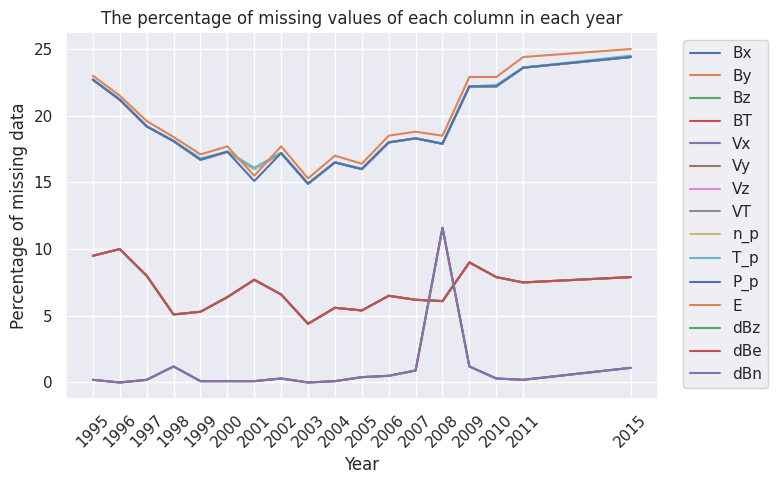

In [ ]:
df_NAN_percent["year"] = df_NAN_percent["year"].astype("category")

plt.figure(figsize=(8, 5))
for column in df_NAN_percent.columns:
    if column not in ['year']:  # Skip 'year' and 'sum' column for the y-axis
        plt.plot(df_NAN_percent['year'], df_NAN_percent[column], label=column)

plt.xlabel('Year')
plt.ylabel('Percentage of missing data')
plt.title('The percentage of missing values of each column in each year')

# Show all year values on the x-axis and rotate them at a 45-degree angle
plt.xticks(ticks=df_NAN_percent['year'], labels=df_NAN_percent['year'], rotation=45)

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))  # To show legend
plt.tight_layout()  # Adjust the layout to prevent labels from being cut off
plt.show()


### 5.3.4. Missing values treatment

**Notes**:
1. Although there are 97,333 rows with missing values, just **one percent** of rows have **NAs**. So, this is not a big deal. The number of rows with missing values (NAs) corresponds to a period of approximately 68.0 days within the time span from 1995 to 2015.    
2. Dealing with NAs:
    - Drop rows with NAs    
    - Fill NAs with:
        - Mean
        - Median
        - Mode
        - Constant number or string, like 0 or 'unknown'
        - MICE forest
        - Miss Forest
        - KNN Imputer

3. As this datset is a time series dataset, the rows with missing values should not be dropped. Because the track of time will be disrupted. So, it is better to fill NAs.

4. In the first step, we fill the missing values with Median. When the final model is selected, we fill in the missing values with all other methods and finally choose the best one.


In [ ]:
# Convert the 'date_time' column to datetime
df0['date_time'] = pd.to_datetime(df0['date_time'])

# Fill NA values with the median of each column
df_filled = df0.fillna(df0.median())
display("df_filled:", df_filled.shape, df_filled.head(2)) ; print()

<ipython-input-117-3f7ca2a8f83d>:5: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



'df_filled:'

(9466560, 16)

,date_time,Bx,By,Bz,BT,Vx,Vy,Vz,VT,n_p,T_p,P_p,E,dBz,dBe,dBn
0,1995-01-01 00:00:00,0.19,0.9,-0.98,1.35,-413.1,-3.0,-2.4,414.3,4.93,67806.5,1.79,0.01,4.760194,-1.656206,3.860474
1,1995-01-01 00:01:00,0.19,0.9,-0.98,1.35,-413.1,-3.0,-2.4,414.3,4.93,67806.5,1.79,0.01,4.756423,-1.681890,3.883245


In [ ]:
# To save the dataset
years = np.sort(df_filled.date_time.dt.year.unique())
filename1 = f"filled_median_{years[0]}-2011_{years[-1]}.parq.gzip" ; print(f"filename: {filename1}") ; print()
df_filled.to_parquet(os.path.join(path_data, filename1), index=False, compression="gzip")
df_filled = pd.read_parquet(os.path.join(path_data, filename1)) ; display("df_filled:", df_filled.shape, df_filled.head(2)) ; print()
print()
display(os.listdir(path_data))

filename: filled_median_1995-2011_2015.parq.gzip



'df_filled:'

(9466560, 16)

,date_time,Bx,By,Bz,BT,Vx,Vy,Vz,VT,n_p,T_p,P_p,E,dBz,dBe,dBn
0,1995-01-01 00:00:00,0.19,0.9,-0.98,1.35,-413.1,-3.0,-2.4,414.3,4.93,67806.5,1.79,0.01,4.760194,-1.656206,3.860474
1,1995-01-01 00:01:00,0.19,0.9,-0.98,1.35,-413.1,-3.0,-2.4,414.3,4.93,67806.5,1.79,0.01,4.756423,-1.681890,3.883245


['images_GIC_data_download',
 'solar_wind_1995-2022.parq.gzip',
 'SuperMAG_1978-2021.parq.gzip',
 'README.md',
 'merged_1995-2011_2015.parq.gzip',
 'merged_1995-2011_2015_Wierd_Values_replaced_with_NAs.parq.gzip',
 'filled_median_1995-2011_2015.parq.gzip']

# 6.&nbsp;Feature Engineering (dBH)

In [ ]:
filename1 = "filled_median_1995-2011_2015.parq.gzip"

df_dBH = (
    pd.read_parquet(os.path.join(path_data, filename1))
    # .pipe(print_details)#, "merged_1995-2011_2015.parq.gzip")
    .assign(dBH = lambda df: np.sqrt(df.dBe ** 2 + df.dBn ** 2) )
    # .pipe(print_details, "dBH = sqrt(dBe**2 + dBn**2)")
    .drop(columns=["dBe", "dBn"])
    .pipe(print_details, "dropped: dBe & dBn")
)


 Stage: dropped: dBe & dBn


(9466560, 15)

,date_time,Bx,By,Bz,BT,Vx,Vy,Vz,VT,n_p,T_p,P_p,E,dBz,dBH
0,1995-01-01 00:00:00,0.19,0.9,-0.98,1.35,-413.1,-3.0,-2.4,414.3,4.93,67806.5,1.79,0.01,4.760194,4.200747
1,1995-01-01 00:01:00,0.19,0.9,-0.98,1.35,-413.1,-3.0,-2.4,414.3,4.93,67806.5,1.79,0.01,4.756423,4.231825


In [ ]:
df_dBH.dtypes


date_time    datetime64[ns]
Bx                  float64
By                  float64
Bz                  float64
BT                  float64
Vx                  float64
Vy                  float64
Vz                  float64
VT                  float64
n_p                 float64
T_p                 float64
P_p                 float64
E                   float64
dBz                 float32
dBH                 float32
dtype: object

In [ ]:
df_dBH.isna().sum()


date_time    0
Bx           0
By           0
Bz           0
BT           0
Vx           0
Vy           0
Vz           0
VT           0
n_p          0
T_p          0
P_p          0
E            0
dBz          0
dBH          0
dtype: int64

# 7.&nbsp;Normalization

In [ ]:
# List of columns to normalize
columns_to_normalize = ['Bx', 'By', 'Bz', 'BT', 'Vx', 'Vy', 'Vz', 'VT', 'n_p', 'T_p', 'P_p', 'E', 'dBz', 'dBH']

# Normalize the specified columns
df_normalized = df_dBH[columns_to_normalize].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Add the 'date_time' column to the normalized DataFrame
df_normalized['date_time'] = df_dBH['date_time']

# Reordering columns to have 'date_time' as the first column
df_normalized = df_normalized[['date_time'] + [col for col in df_normalized if col != 'date_time']]
display("df_normalized", df_normalized.shape, df_normalized.head(2)) ; print()


'df_normalized'

(9466560, 15)

,date_time,Bx,By,Bz,BT,Vx,Vy,Vz,VT,n_p,T_p,P_p,E,dBz,dBH
0,1995-01-01 00:00:00,0.555556,0.464642,0.440842,0.016898,0.673642,0.721859,0.404199,0.217386,0.067952,0.008663,0.018505,0.566231,0.667948,0.001978
1,1995-01-01 00:01:00,0.555556,0.464642,0.440842,0.016898,0.673642,0.721859,0.404199,0.217386,0.067952,0.008663,0.018505,0.566231,0.667946,0.001992


In [ ]:
# To save the dataset
years = np.sort(df_normalized.date_time.dt.year.unique())
filename1 = f"filled_median_engineered_normalized_{years[0]}-2011_{years[-1]}.parq.gzip" ; print(f"filename: {filename1}") ; print()
df_normalized.to_parquet(os.path.join(path_data, filename1), index=False, compression="gzip")
df_normalized = pd.read_parquet(os.path.join(path_data, filename1)) ; display("df_normalized:", df_normalized.shape, df_normalized.head(2)) ; print()
print()
display(os.listdir(path_data))

filename: filled_median_engineered_normalized_1995-2011_2015.parq.gzip



'df_normalized:'

(9466560, 15)

,date_time,Bx,By,Bz,BT,Vx,Vy,Vz,VT,n_p,T_p,P_p,E,dBz,dBH
0,1995-01-01 00:00:00,0.555556,0.464642,0.440842,0.016898,0.673642,0.721859,0.404199,0.217386,0.067952,0.008663,0.018505,0.566231,0.667948,0.001978
1,1995-01-01 00:01:00,0.555556,0.464642,0.440842,0.016898,0.673642,0.721859,0.404199,0.217386,0.067952,0.008663,0.018505,0.566231,0.667946,0.001992


['images_GIC_data_download',
 'solar_wind_1995-2022.parq.gzip',
 'SuperMAG_1978-2021.parq.gzip',
 'README.md',
 'merged_1995-2011_2015.parq.gzip',
 'merged_1995-2011_2015_Wierd_Values_replaced_with_NAs.parq.gzip',
 'filled_median_1995-2011_2015.parq.gzip',
 'filled_median_engineered_normalized_1995-2011_2015.parq.gzip']

# 8.&nbsp;Plots

In [ ]:
# dfc: df_clean
filename1 = "filled_median_engineered_normalized_1995-2011_2015.parq.gzip"
dfc = pd.read_parquet(os.path.join(path_data, filename1)) ; display("dfc:", dfc.shape, dfc.head(2)) ; print()


'dfc:'

(9466560, 15)

,date_time,Bx,By,Bz,BT,Vx,Vy,Vz,VT,n_p,T_p,P_p,E,dBz,dBH
0,1995-01-01 00:00:00,0.555556,0.464642,0.440842,0.016898,0.673642,0.721859,0.404199,0.217386,0.067952,0.008663,0.018505,0.566231,0.667948,0.001978
1,1995-01-01 00:01:00,0.555556,0.464642,0.440842,0.016898,0.673642,0.721859,0.404199,0.217386,0.067952,0.008663,0.018505,0.566231,0.667946,0.001992


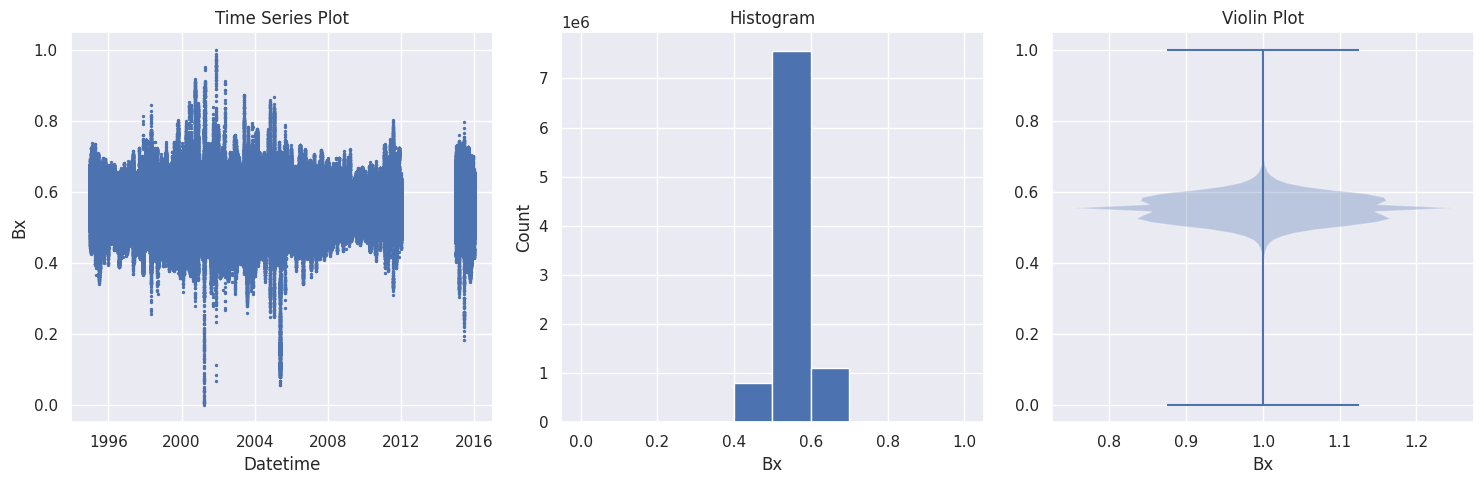

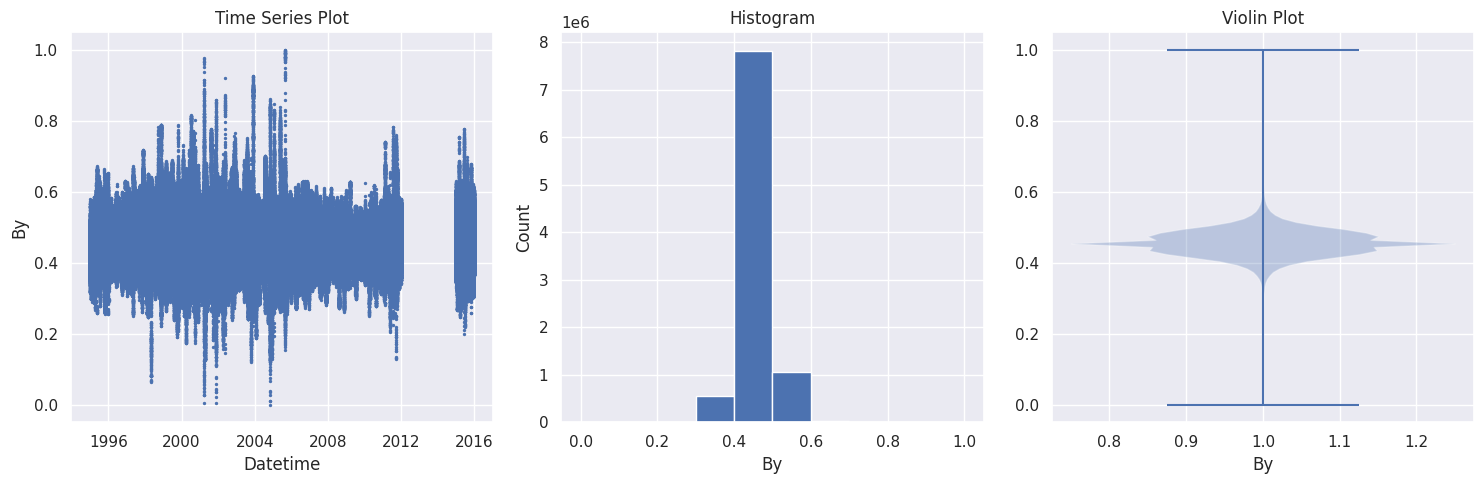

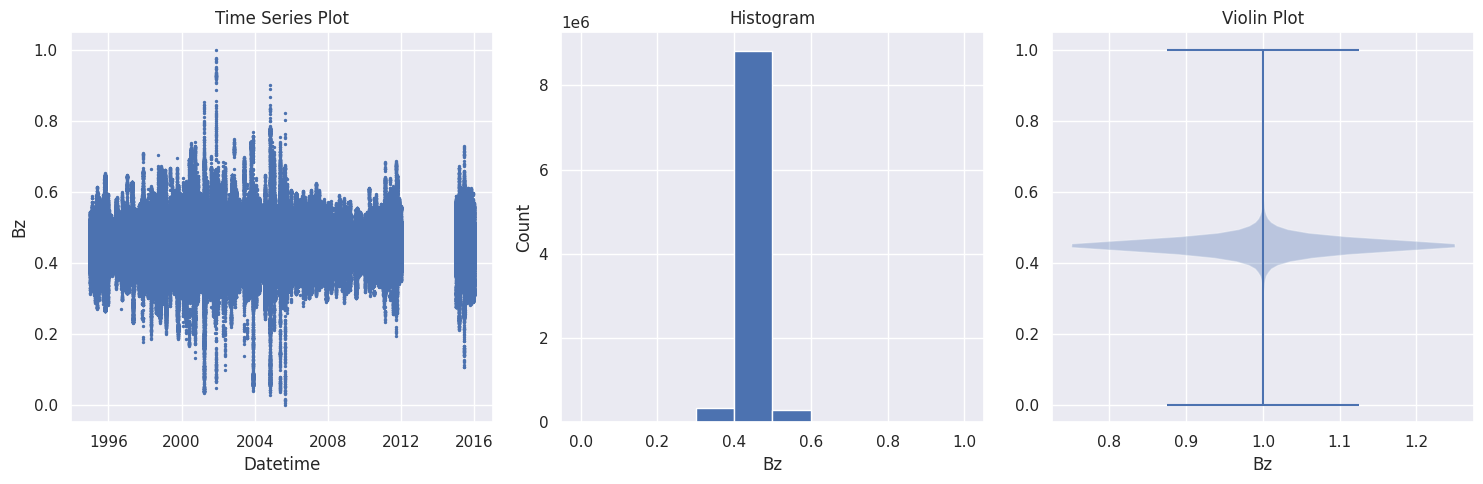

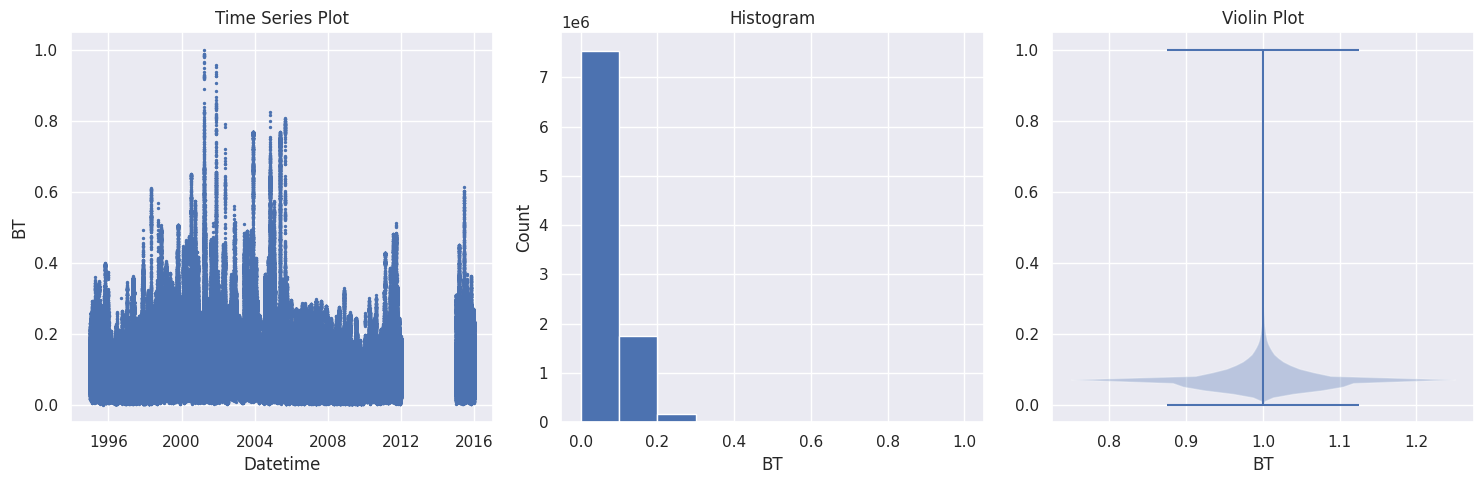

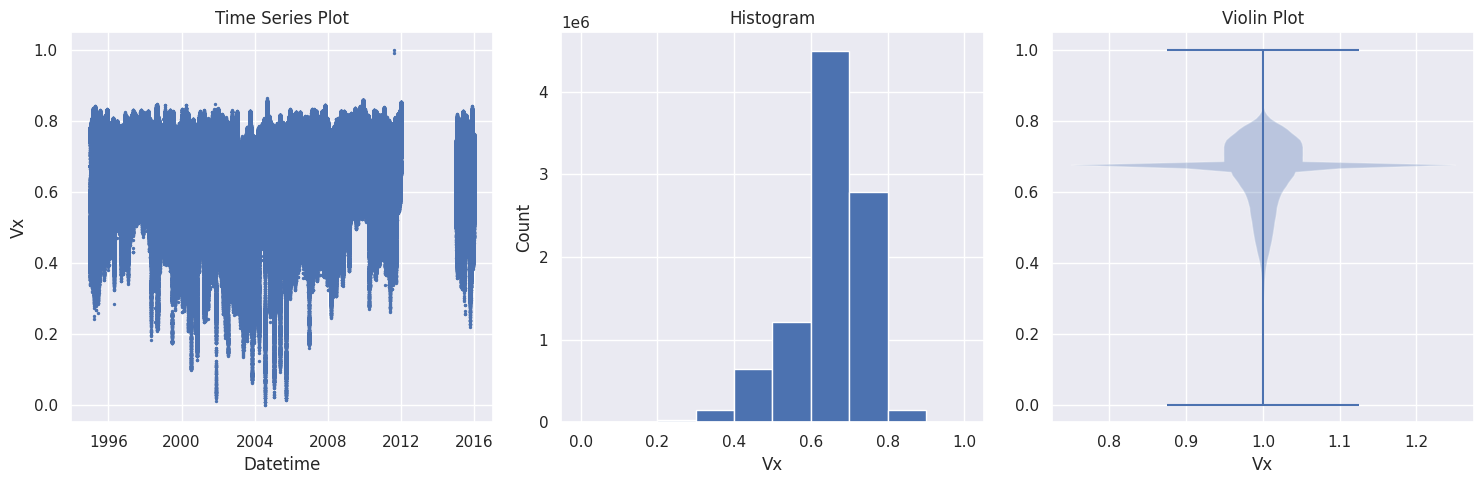

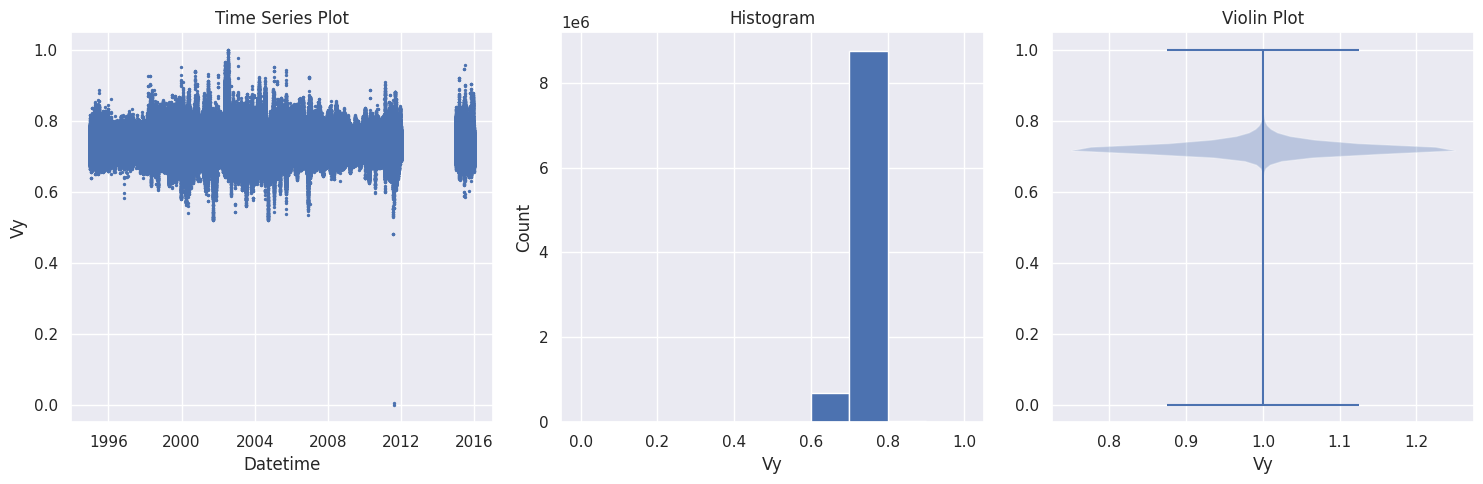

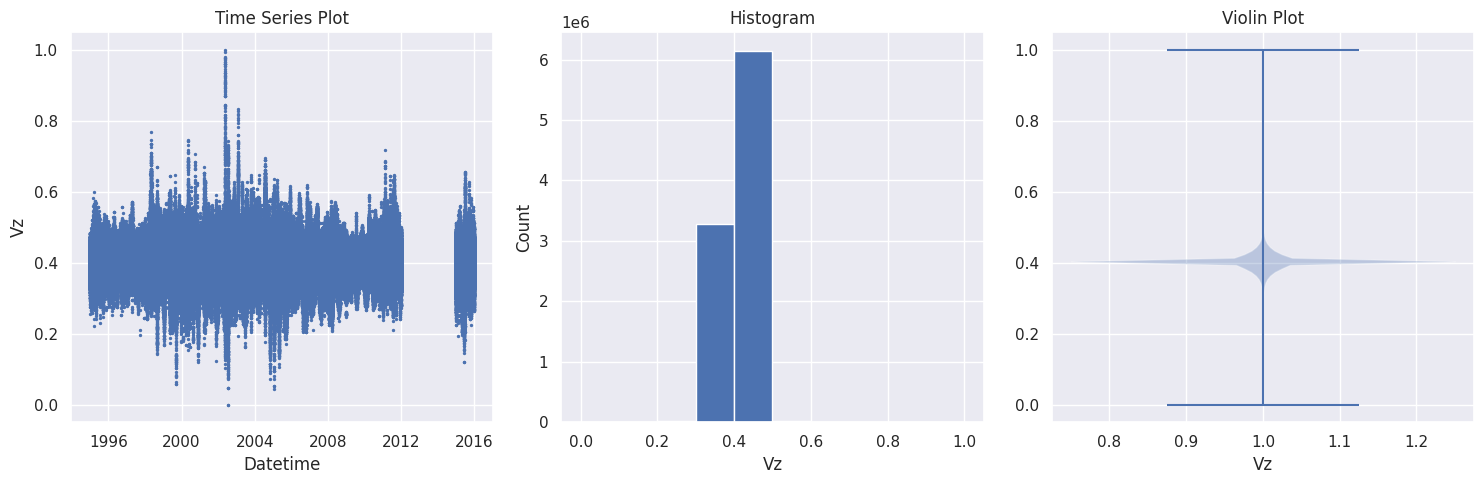

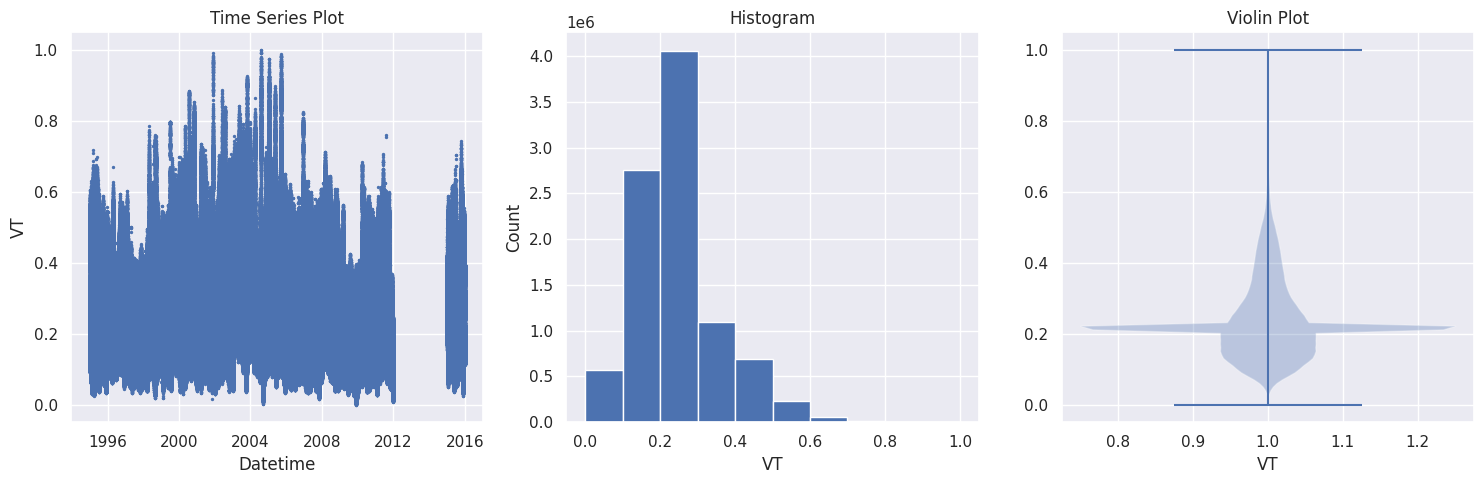

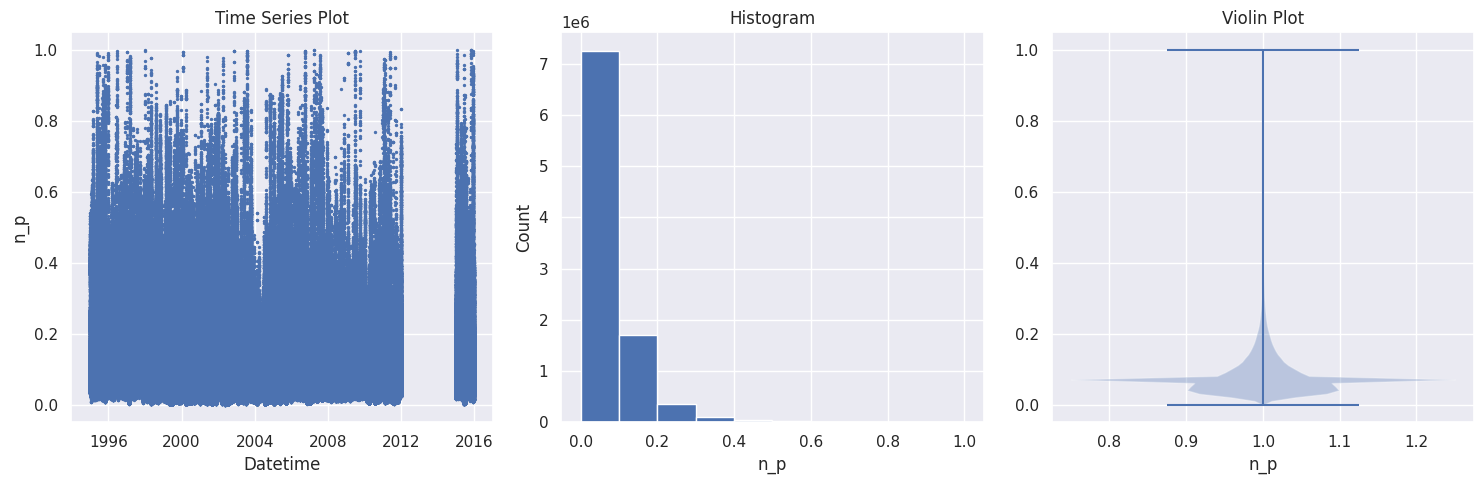

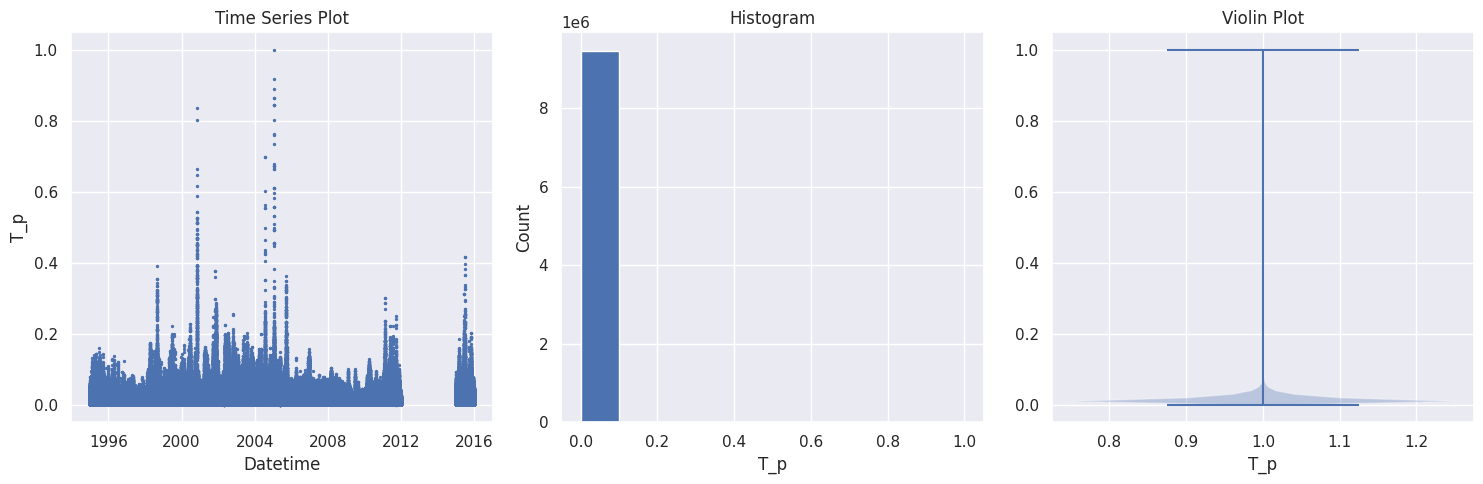

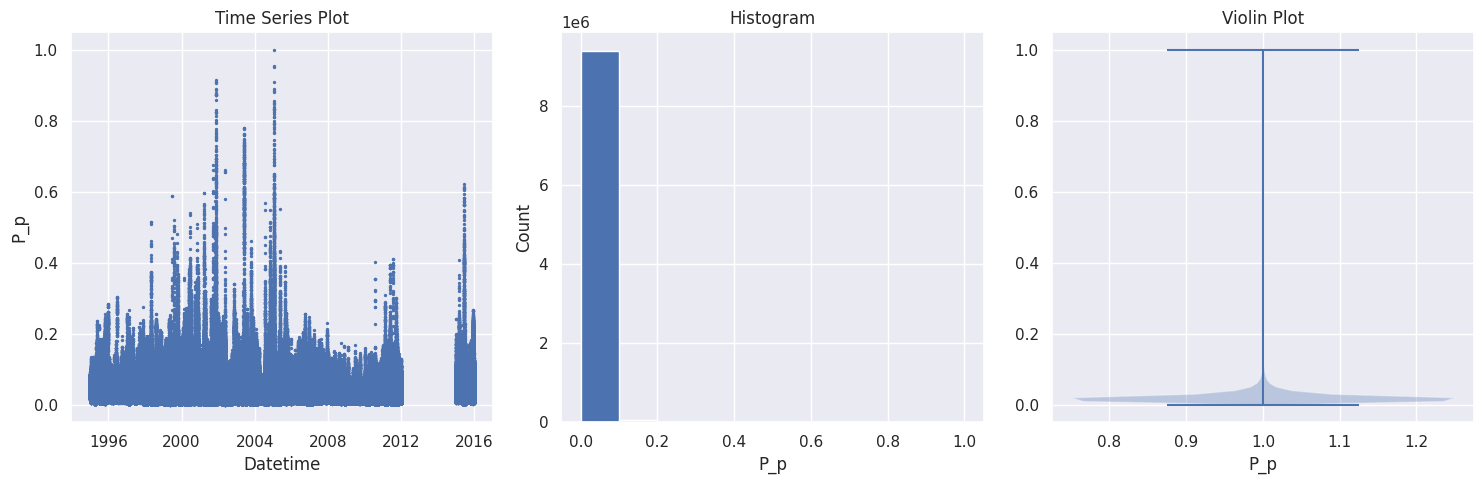

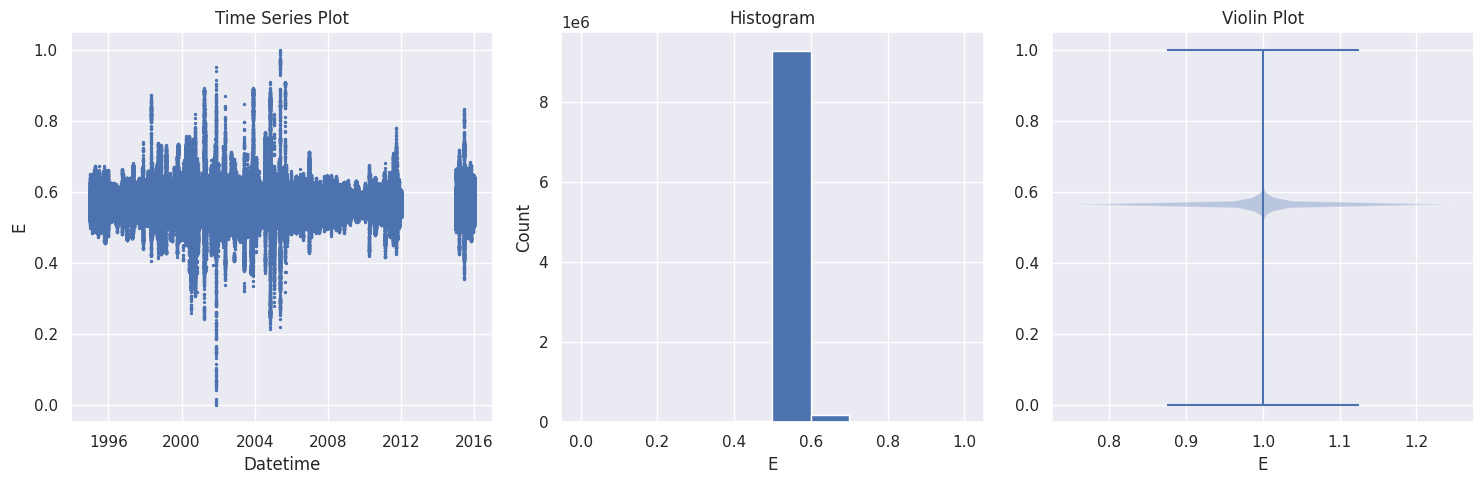

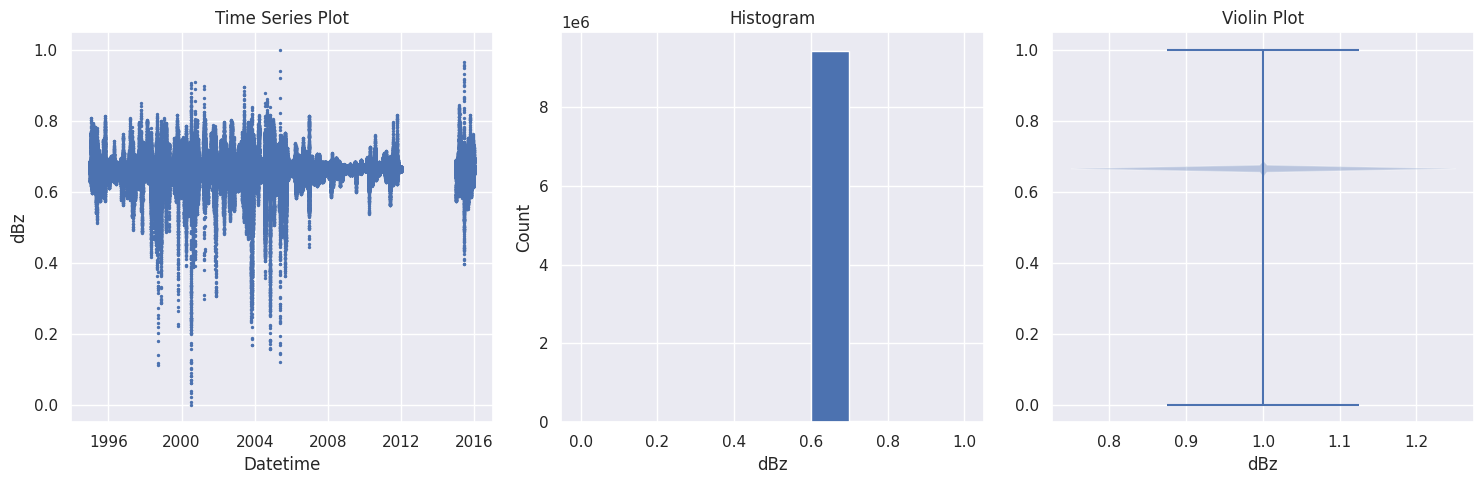

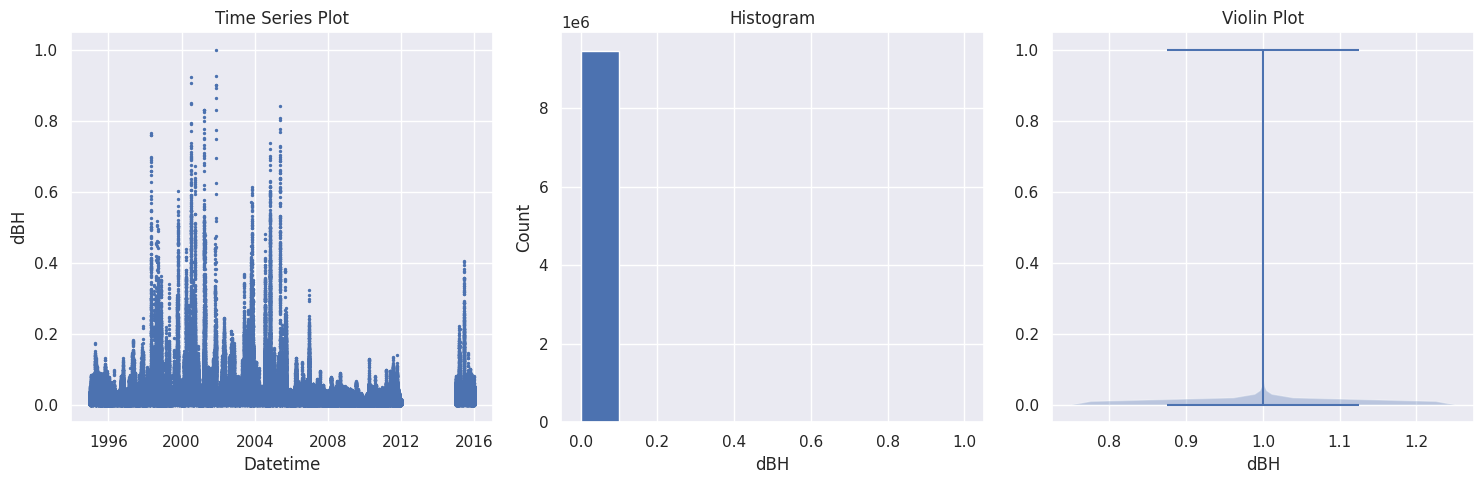

In [ ]:
for col in dfc.columns:
    if col != "date_time":
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        # scatter plot
        ax[0].scatter(dfc["date_time"], dfc[col], s=2)
        ax[0].set_title("Time Series Plot")
        ax[0].set_xlabel("Datetime")
        ax[0].set_ylabel(col)

        # histogram
        ax[1].hist(dfc[col], bins=10)
        ax[1].set_title("Histogram")
        ax[1].set_xlabel(col)
        ax[1].set_ylabel("Count")

        # violin plot
        ax[2].violinplot(dfc[col].dropna())  # drop NA values for the violin plot
        ax[2].set_title("Violin Plot")
        ax[2].set_xlabel(col)

        plt.tight_layout()
        plt.show()


# Archive

In [ ]:
# make the below code integrated so that for each column make 3 plots in a row:

# scatter: Plot all columns based on the column `date_time`
for col in df_filled.columns:
    if col != "date_time":
        fig, ax = plt.subplots(figsize=(5, 5))
        plt.scatter(df_filled["date_time"], df_filled[col], s=2)
        ax.set_title("Time Series Plot")
        ax.set_xlabel("Datetime")
        ax.set_ylabel(col)
        plt.show()


# histogram: Plot all columns based on the column `date_time`
for col in df_filled.columns:
    if col != "date_time":
        fig, ax = plt.subplots(figsize=(5, 5))
        plt.hist(df_filled[col], bins=10)
        ax.set_title("Histogram")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        plt.show()


# Plot all columns based on the column `date_time`
for col in df_filled.columns:
    if col != "date_time":
        fig, ax = plt.subplots(figsize=(5, 5))
        plt.violinplot(df_filled[col])
        ax.set_title("Violin Plot")
        ax.set_xlabel(col)
        plt.show()

## 5.3. Dealing with NAs

### 5.3.1. Missing values exploration (streaks)

In [ ]:
years = (dfH.date_time.dt.year.min(), dfH.date_time.dt.year.max())
days = np.ceil(97333 / (24*60))
print(f"NAs are equvalent of {days} days out of {years} years.")

NAs are equvalent of 68.0 days out of (1995, 2015) years.


In [ ]:
df_NAs = (
    dfH.query("dBH.isna()")
    .pipe(print_details, "df_NAs")
)



 Stage: df_NAs


(97333, 15)

,date_time,Bx,By,Bz,BT,Vx,Vy,Vz,VT,n_p,T_p,P_p,E,dBz,dBH
57681,1995-02-10 01:21:00,3.56,3.62,3.26,6.03,-349.4,-10.0,-0.8,349.6,7.55,9594.0,1.85,-1.6,NaN,NaN
57682,1995-02-10 01:22:00,3.60,3.61,3.25,6.04,-349.9,-9.7,0.8,350.1,7.42,10123.0,1.82,-1.6,NaN,NaN


In [ ]:
dfH.iloc[57680:57690, : ]

,date_time,Bx,By,Bz,BT,Vx,Vy,Vz,VT,n_p,T_p,P_p,E,dBz,dBH
57680,1995-02-10 01:20:00,3.46,3.57,3.34,5.99,-348.3,-9.8,-0.4,348.5,7.65,9428.0,1.86,-1.61,0.884941,0.277953
57681,1995-02-10 01:21:00,3.56,3.62,3.26,6.03,-349.4,-10.0,-0.8,349.6,7.55,9594.0,1.85,-1.60,NaN,NaN
57682,1995-02-10 01:22:00,3.60,3.61,3.25,6.04,-349.9,-9.7,0.8,350.1,7.42,10123.0,1.82,-1.60,NaN,NaN
57683,1995-02-10 01:23:00,3.62,3.54,3.27,6.03,-349.7,-9.0,0.4,349.8,7.42,10247.0,1.82,-1.59,NaN,NaN
57684,1995-02-10 01:24:00,3.58,3.54,3.29,6.02,-349.7,-9.0,0.4,349.8,7.42,10247.0,1.82,-1.60,NaN,NaN
57685,1995-02-10 01:25:00,3.54,3.52,3.36,6.02,99999.9,99999.9,99999.9,99999.9,999.99,9999999.0,99.99,999.99,NaN,NaN
57686,1995-02-10 01:26:00,3.54,3.48,3.39,6.02,-349.2,-8.2,0.2,349.3,7.59,9596.0,1.85,-1.61,NaN,NaN
57687,1995-02-10 01:27:00,3.51,3.40,3.53,6.02,-349.2,-8.2,0.2,349.3,7.59,9596.0,1.85,-1.65,NaN,NaN
57688,1995-02-10 01:28:00,3.52,3.50,3.45,6.05,-349.7,-8.9,-0.2,349.8,7.51,9155.0,1.84,-1.64,NaN,NaN
57689,1995-02-10 01:29:00,3.47,3.57,3.41,6.04,-349.8,-9.0,-0.2,349.9,7.49,9174.0,1.83,-1.64,NaN,NaN


In [ ]:
np.sort(df_NAs.date_time.dt.year.unique())

array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2015])

In [ ]:
# missing-streaks exploration

# Identify start of missing-streaks. Then label missing-streaks.
dfH["streak"] = (dfH.dBH.isnull() & dfH.dBH.shift().notnull()).cumsum()
# Count missing values within each missing streak
missing_streaks_lengths = dfH[dfH.dBH.isnull()].groupby("streak").size()

print(f"The number of missing-streaks: {len(missing_streaks_lengths)  }")
print()
print(f"The maximum length of missing-streaks: {missing_streaks_lengths.max() }")
print(f"The minimum length of missing-streaks: {missing_streaks_lengths.min() }")
print(f"The average length of missing-streaks: {round(missing_streaks_lengths.mean())}")
print(f"The Median length of missing-streaks: {round(missing_streaks_lengths.median())}")
print(f"The number of unique length of missing-streaks: {missing_streaks_lengths.nunique()}")
print(f"The number of unique value-count of length of missing-streaks: {missing_streaks_lengths.value_counts().nunique()}")
print(f"The unique value-count of length of missing-streaks: {missing_streaks_lengths.value_counts().unique()}")


The number of missing-streaks: 7803

The maximum length of missing-streaks: 9754
The minimum length of missing-streaks: 3
The average length of missing-streaks: 12
The Median length of missing-streaks: 7
The number of unique length of missing-streaks: 120
The number of unique value-count of length of missing-streaks: 16
The unique value-count of length of missing-streaks: [3637 1539  966  794  477   79   71   34   15   12   11    7    4    3
    2    1]


In [ ]:
df_missing_streaks = missing_streaks_lengths.value_counts().reset_index()
df_missing_streaks = df_missing_streaks.rename(columns={'index': 'unique_length', 0: 'number_of_streaks'})
display("df_missing_streaks:", df_missing_streaks.shape, df_missing_streaks.head(120))

'df_missing_streaks:'

(120, 2)

,unique_length,number_of_streaks
0,7,3637
1,6,1539
2,8,966
3,5,794
4,4,477
...,...,...
115,1481,1
116,145,1
117,57,1
118,105,1


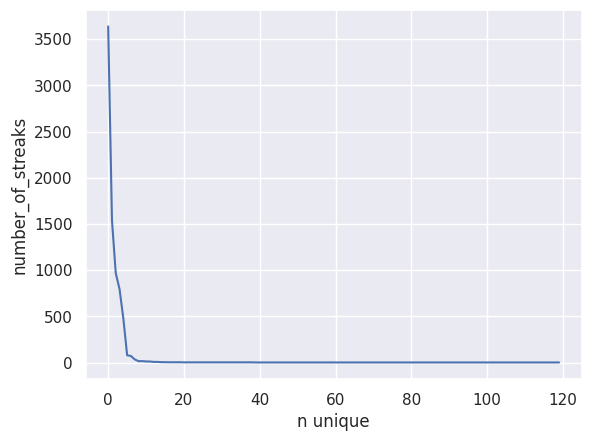

In [ ]:
plt.plot(df_missing_streaks.number_of_streaks)
plt.xlabel('n unique')
plt.ylabel('number_of_streaks')
plt.show()


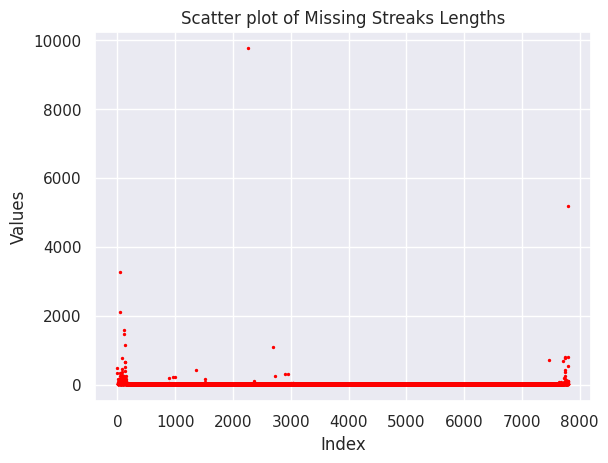

In [ ]:
plt.scatter(missing_streaks_lengths.index,
            missing_streaks_lengths.values,
            color='red',
            s=2
)
plt.title('Scatter plot of Missing Streaks Lengths')
plt.xlabel('Index')
plt.ylabel('Values')
plt.show()


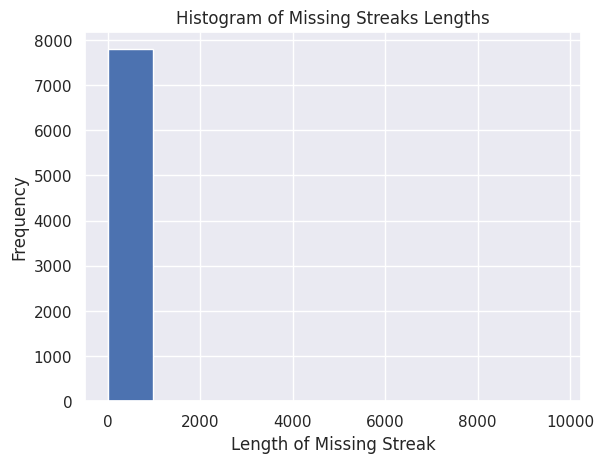

In [ ]:
plt.hist(missing_streaks_lengths)
plt.title('Histogram of Missing Streaks Lengths')
plt.xlabel('Length of Missing Streak')
plt.ylabel('Frequency')
plt.show()


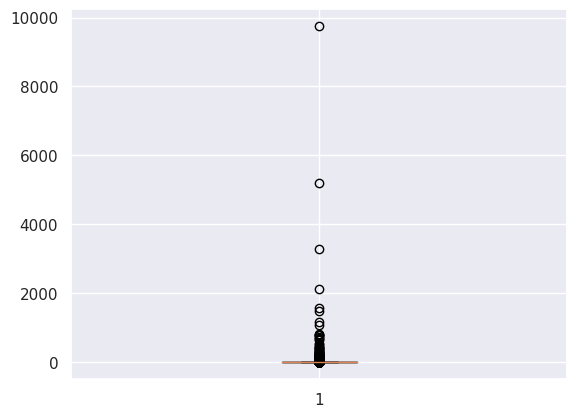

In [ ]:
plt.boxplot(missing_streaks_lengths.values)
plt.show()


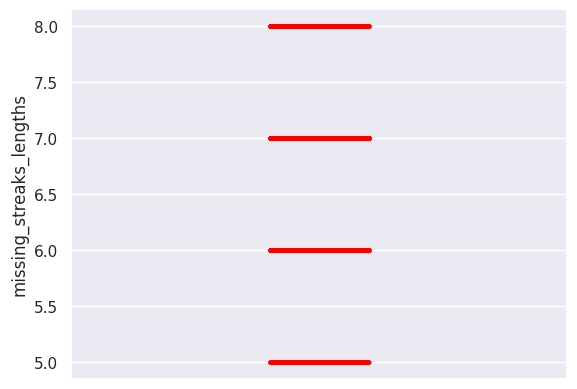

In [ ]:

# Remove outliers using IQR method
Q1 = missing_streaks_lengths.quantile(0.25)
Q3 = missing_streaks_lengths.quantile(0.75)
IQR = Q3 - Q1
filtered = missing_streaks_lengths[~((missing_streaks_lengths < (Q1 - 1.5 * IQR)) | (missing_streaks_lengths > (Q3 + 1.5 * IQR)))]

# Convert filtered series to DataFrame
df_filtered = pd.DataFrame(filtered, columns=['missing_streaks_lengths'])

# Create a stripplot (a scatterplot where one variable is categorical) with jitter
sns.stripplot(data=df_filtered, y='missing_streaks_lengths', jitter=True, color="red", size=3)

plt.show()


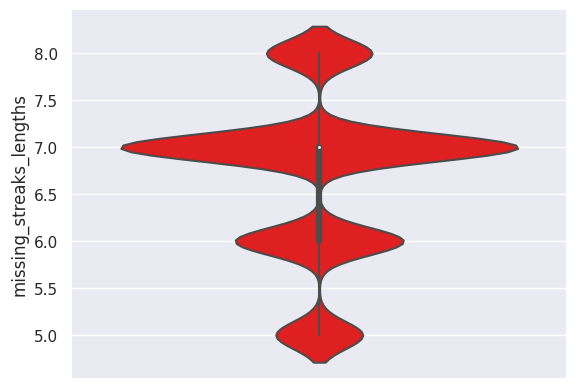

In [ ]:
import seaborn as sns

# Remove outliers using IQR method as explained above
Q1 = missing_streaks_lengths.quantile(0.25)
Q3 = missing_streaks_lengths.quantile(0.75)
IQR = Q3 - Q1
filtered = missing_streaks_lengths[~((missing_streaks_lengths < (Q1 - 1.5 * IQR)) | (missing_streaks_lengths > (Q3 + 1.5 * IQR)))]

# Convert filtered series to DataFrame
df_filtered = pd.DataFrame(filtered, columns=['missing_streaks_lengths'])

# Create a violin plot
sns.violinplot(data=df_filtered, y='missing_streaks_lengths', color="red")

plt.show()


## 5.4. values exploration

### 5.4.1. Statistics

In [ ]:
filename_filled = "filled_merged_1995-2011_2015.parq.gzip"
df_filled = pd.read_parquet(os.path.join(path_data, filename_filled)) ; display("df_filled:", df_filled.shape, df_filled.head(2)) ; print()


'df_filled:'

(9466560, 15)

,date_time,Bx,By,Bz,BT,Vx,Vy,Vz,VT,n_p,T_p,P_p,E,dBz,dBH
0,1995-01-01 00:00:00,0.19,0.9,-0.98,1.35,99999.9,99999.9,99999.9,99999.9,999.99,9999999.0,99.99,999.99,4.760194,4.200747
1,1995-01-01 00:01:00,0.19,0.9,-0.98,1.35,99999.9,99999.9,99999.9,99999.9,999.99,9999999.0,99.99,999.99,4.756423,4.231825


In [ ]:
# Create a function to format the float values
def my_float_format(value):
    return "{:.2f}".format(value)

# Set the float format to the function
pd.set_option("display.float_format", my_float_format)

# Print the summary statistics
print(df_filled.describe())

              Bx         By         Bz         BT         Vx         Vy  \
count 9466560.00 9466560.00 9466560.00 9466560.00 9466560.00 9466560.00   
mean      695.33     695.42     695.33     700.87   18657.15   19009.15   
std      2543.62    2543.59    2543.62    2542.10   39408.95   39238.31   
min       -49.51     -48.05     -52.51       0.12   -1073.00    -864.90   
25%        -2.56      -2.53      -1.58       4.04    -467.90     -12.10   
50%         0.41       0.51       0.23       5.47    -387.20       2.70   
75%         3.33       3.55       2.26       7.73    -314.20      34.20   
max      9999.99    9999.99    9999.99    9999.99   99999.90   99999.90   

              Vz         VT        n_p        T_p        P_p          E  \
count 9466560.00 9466560.00 9466560.00 9466560.00 9466560.00 9466560.00   
mean    19007.70   19363.71     195.31 1983264.86      20.76     194.54   
std     39239.01   39066.64     389.88 3890703.21      38.36     395.83   
min      -310.40     230

In [ ]:
display("df_filled:", df_filled.shape, df_filled.head(10)) ; print()

'df_filled:'

(9466560, 15)

,date_time,Bx,By,Bz,BT,Vx,Vy,Vz,VT,n_p,T_p,P_p,E,dBz,dBH
0,1995-01-01 00:00:00,0.19,0.90,-0.98,1.35,99999.90,99999.90,99999.90,99999.90,999.99,9999999.00,99.99,999.99,4.76,4.20
1,1995-01-01 00:01:00,0.19,0.90,-0.98,1.35,99999.90,99999.90,99999.90,99999.90,999.99,9999999.00,99.99,999.99,4.76,4.23
2,1995-01-01 00:02:00,0.24,0.99,-1.02,1.45,99999.90,99999.90,99999.90,99999.90,999.99,9999999.00,99.99,999.99,3.75,4.26
3,1995-01-01 00:03:00,0.19,1.02,-0.98,1.44,99999.90,99999.90,99999.90,99999.90,999.99,9999999.00,99.99,999.99,3.75,4.29
4,1995-01-01 00:04:00,-0.14,0.91,-0.81,1.25,99999.90,99999.90,99999.90,99999.90,999.99,9999999.00,99.99,999.99,3.74,4.33
5,1995-01-01 00:05:00,0.09,0.94,-0.78,1.26,-310.30,-1.60,25.50,311.40,18.46,17347.00,3.58,0.16,3.74,4.36
6,1995-01-01 00:06:00,9999.99,9999.99,9999.99,9999.99,99999.90,99999.90,99999.90,99999.90,999.99,9999999.00,99.99,999.99,3.74,5.28
7,1995-01-01 00:07:00,9999.99,9999.99,9999.99,9999.99,99999.90,99999.90,99999.90,99999.90,999.99,9999999.00,99.99,999.99,3.73,3.86
8,1995-01-01 00:08:00,9999.99,9999.99,9999.99,9999.99,99999.90,99999.90,99999.90,99999.90,999.99,9999999.00,99.99,999.99,3.73,3.89
9,1995-01-01 00:09:00,9999.99,9999.99,9999.99,9999.99,99999.90,99999.90,99999.90,99999.90,999.99,9999999.00,99.99,999.99,3.72,3.92


In [ ]:
col_results = ["year", "sum"] + df_filled.columns[~df_filled.columns.isin(["date_time", "dBz", "dBH"])].to_list()
df_results = pd.DataFrame(columns=col_results)
years = list(df_filled.date_time.dt.year.unique())
year_sum = {}
row_index = -1

for year in years:
    cond_years = (df_filled.date_time.dt.year == year)
    row_index += 1
    dict_col = {}
    df_year = df_filled.loc[cond_years, : ]
    for col in df_year.columns[~df_filled.columns.isin(["date_time", "dBz", "dBH"])]:
        if   (col in ["P_p"]                                ): weird_value =        99
        elif (col in ["n_p", "E"]                           ): weird_value =       999
        elif (col in ["Bx", "By", "Bz", "BT", "dBz", "dBH"] ): weird_value =     9_999
        elif (col in ["Vx", "Vy", "Vz", "VT"]               ): weird_value =    99_999
        elif (col in ["T_p"]                                ): weird_value = 9_999_999
        cond_weird_values = (df_year.loc[:, col] >= weird_value)
        weird_values_count = df_year.loc[cond_weird_values, col].shape[0]
        dict_col.update({col:weird_values_count})
        df_results.at[row_index, col] = weird_values_count
    df_results.at[row_index, "sum"] = sum(dict_col.values())
    df_results.at[row_index, "year"] = year
    # print(f"------------------------------------------------------------------")
    # print(f"{year}   sum: {sum(dict_col.values())}")
    # print(dict_col)
    # year_sum.update({year:sum(dict_col.values())})
    # print()
# print(f"======================================================================")
# key_min_year = min(year_sum, key=year_sum.get)
# key_max_year = max(year_sum, key=year_sum.get)
# print(f"max: {year_sum[key_max_year]} in year {key_max_year}")
# print(f"min: {year_sum[key_min_year]} in year {key_min_year}")
display("df_results:", df_results.shape, df_results.head(18))


'df_results:'

(18, 14)

,year,sum,Bx,By,Bz,BT,Vx,Vy,Vz,VT,n_p,T_p,P_p,E
0,1995,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1996,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1997,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1998,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1999,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2000,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2001,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2002,0,0,0,0,0,0,0,0,0,0,0,0,0
8,2003,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2004,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_results.dtypes

year    object
sum     object
Bx      object
By      object
Bz      object
BT      object
Vx      object
Vy      object
Vz      object
VT      object
n_p     object
T_p     object
P_p     object
E       object
dtype: object

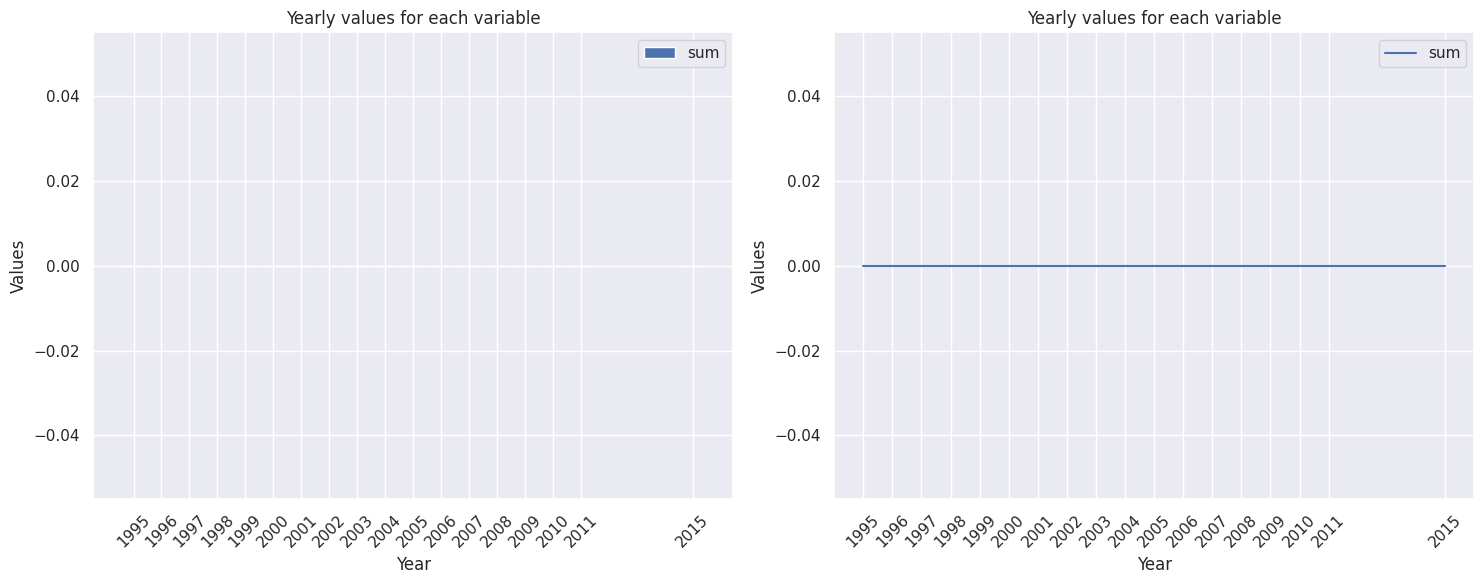

In [ ]:
df_results["year"] = df_results["year"].astype("category")

fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # Create a figure with 1 row and 2 columns of subplots

# Plot on the first subplot
axs[0].bar(df_results['year'], df_results["sum"], label="sum")
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Values')
axs[0].set_title('Yearly values for each variable')
axs[0].legend()

# Set x-ticks and rotate labels on the first subplot
axs[0].set_xticks(df_results['year'])
axs[0].set_xticklabels(df_results['year'], rotation=45)

# Plot on the second subplot
axs[1].plot(df_results['year'], df_results["sum"], label="sum")
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Values')
axs[1].set_title('Yearly values for each variable')
axs[1].legend()

# Set x-ticks and rotate labels on the second subplot
axs[1].set_xticks(df_results['year'])
axs[1].set_xticklabels(df_results['year'], rotation=45)

plt.tight_layout()  # Adjust the layout to prevent labels from being cut off
plt.show()


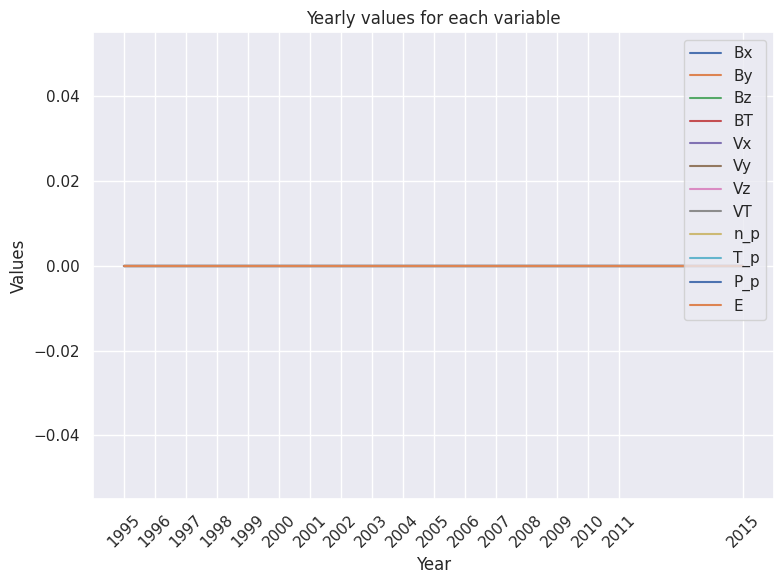

In [ ]:
df_results["year"] = df_results["year"].astype("category")

plt.figure(figsize=(8, 6))
for column in df_results.columns:
    if column not in ['year', 'sum']:  # Skip 'year' and 'sum' column for the y-axis
        plt.plot(df_results['year'], df_results[column], label=column)

plt.xlabel('Year')
plt.ylabel('Values')
plt.title('Yearly values for each variable')

# Show all year values on the x-axis and rotate them at a 45-degree angle
plt.xticks(ticks=df_results['year'], labels=df_results['year'], rotation=45)

plt.legend()  # To show legend
plt.tight_layout()  # Adjust the layout to prevent labels from being cut off
plt.show()


In [ ]:
for col in df_filled.columns[~df_filled.columns.isin(["date_time", "dBz", "dBH"])]:
    if   (col in ["P_p"]                                ): weird_value =        99
    elif (col in ["n_p", "E"]                           ): weird_value =       999
    elif (col in ["Bx", "By", "Bz", "BT", "dBz", "dBH"] ): weird_value =     9_999
    elif (col in ["Vx", "Vy", "Vz", "VT"]               ): weird_value =    99_999
    elif (col in ["T_p"]                                ): weird_value = 9_999_999

    print(f"------------------------------------------------------------------")
    print(f'------------> ["{col}"] ')
    print(f"                       rows: {df_filled[col].shape[0]:,}")
    print(f"     rows with weird values: {(df_filled[col] > weird_value).sum():,}")
    list1 = df_filled.loc[(df_filled[col] > weird_value),:]["date_time"].dt.year.unique()
    list1_str = ' '.join(str(year) for year in list1)
    print(f"    Years with weird values: {list1_str}")
    print(f"The number of unique counts: {df_filled[col].nunique():,}")
    print("value_______count", df_filled[col].value_counts().head())
    print()

------------------------------------------------------------------
------------> ["Bx"] 
                       rows: 9,466,560
     rows with weird values: 0
    Years with weird values: 
The number of unique counts: 5,539
value_______count -2.54    9159
 2.04    9065
-2.46    9061
-2.42    8985
-2.67    8985
Name: Bx, dtype: int64

------------------------------------------------------------------
------------> ["By"] 
                       rows: 9,466,560
     rows with weird values: 0
    Years with weird values: 
The number of unique counts: 7,139
value_______count -1.92    8623
 2.25    8613
-2.04    8597
-2.10    8565
 1.97    8535
Name: By, dtype: int64

------------------------------------------------------------------
------------> ["Bz"] 
                       rows: 9,466,560
     rows with weird values: 0
    Years with weird values: 
The number of unique counts: 7,206
value_______count -0.01    14578
-0.10    14562
-0.03    14556
-0.17    14548
 0.04    14517
Name: Bz, d